# Inference of Gene Regulatory Network using Kinetic Ising Model


In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-04-20


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from scipy.stats import norm
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

import os
import sys
sys.path.append('../')

import lib.NetAnalysis as na
# from lib.import_funcs import *
import lib.fun_plotting as fun_plotting
from lib.ml_wrapper import asynch_reconstruction
import lib.figs_funcs as figfunc
import lib.funcs_raster as funcs_raster
import lib.funcs_general as funcs_general
import lib.funcs_IsingPars as funcs_Ising
import lib.funcs_ko as funcs_ko
import lib.minibulk_funcs as mb


%load_ext autoreload
%autoreload 2

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Initial information

In [3]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [4]:
# genes of OUR dataset
genes_order = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]



# Bulk Data

In [5]:
imp_genes = np.loadtxt(path_data+"general_info/imp_genes.csv", dtype="str")

file_name = path_data+"input_data/geni_IMP.xlsx"
df_bulk_all = pd.read_excel(file_name).set_index(imp_genes).reindex(genes_order)

df_bulk = df_bulk_all.iloc[:,2: ]
df_bulk.head(4)

# df2iL = df.iloc[:,2:18]
# df2i = df.iloc[:,18:]
# ntime=np.array([0, 0, 24, 24, 36, 36, 48, 48, 60, 60, 72, 72, 84, 84, 96, 96])



,GM_2iL_2,GM_2iL_1,GM_24h_2iL_2,GM_24h_2iL_1,GM_36h_2iL_2,GM_36h_2iL_1,GM_48h_2iL_2,GM_48h_2iL_1,GM_60h_2iL_2,GM_60h_2iL_1,...,GM_36h_2i_1,GM_36h_2i_2,GM_48h_2i_1,GM_48h_2i_2,GM_60h_2i_1,GM_60h_2i_2,GM_72h_2i_1,GM_72h_2i_2,GM_84h_2i_1,GM_84h_2i_2
Klf4,721.246075,790.448527,362.034812,507.580169,338.426474,275.595044,109.118435,141.201368,31.593545,46.465603,...,15.825195,7.814844,19.079327,14.208553,38.803582,25.553683,17.314668,14.76264,31.121266,16.477378
Klf2,300.890974,288.413501,124.602767,102.125740,87.270395,86.229124,51.552016,27.900029,31.593545,34.418965,...,25.056559,32.040862,42.928486,27.909658,39.896640,34.467758,16.527638,14.76264,13.103691,5.703708
Esrrb,179.939742,201.400614,103.999160,83.834562,47.694286,52.413781,24.916808,11.228061,6.651273,6.453556,...,3.956299,3.125938,4.769832,1.522345,2.186117,4.159902,3.148121,1.84533,1.637961,3.168726
Tfcp2l1,797.584148,796.803401,135.395133,111.271328,69.511885,70.166836,22.339207,18.713434,6.097000,6.453556,...,7.912597,5.470391,6.359776,6.089380,7.104881,7.725532,4.722182,9.22665,12.284710,8.238689


# Raw Data

In [6]:
df_raw = pd.read_csv(path_data + "GE_data/imp_genes_raw.csv", header=0, index_col=0, sep=",").reindex(genes_order)
# time_sep = np.loadtxt(path+"GE_data/time_sep.txt", dtype=np.int32)
df_raw.index.name = None

In [7]:
# PST
w_size=150
pst_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

pst_df = pst_df.sort_values(by=['pst'])

# riordino dataframe 
column_names = pst_df["barcodes"]
df_raw_pst = df_raw.reindex(columns = column_names)

df_raw_mb_pst = df_raw_pst.rolling(window = w_size, axis=1).mean().dropna(axis=1)
df_raw_mb_pst = pd.DataFrame(df_raw_mb_pst, index=df_raw_pst.index)
df_raw_mb_pst.head(3)


barcodes,GGCGTCAGTCAACGCC,CTCATGCGTCAGGTAG,CTGCCATAGACCGCCT,AGCCAATCAAATCAGA,CGGGTCATCTGGAGAG,TCATTTGTCATCGGGC,AGCATCAAGTACTGGG,ATTCAGGTCGGTTAGT,TCGATTTTCAATCCGA,TATCCTACATAGGTTC,...,TTTGACTTCGCCACTT,GCCATTCTCATTCACT,GAAACCTGTTGTGCCG,CAACCAAAGCCTCACG,TCCTCTTTCGTCCATC,CTAACCCCACAATGCT,CCACACTCACACCAGC,CACGTTCAGCCGAACA,TGATTCTTCCGTTTCG,CTTGATTCACCATTCC
Klf4,1.340000,1.340000,1.353333,1.353333,1.366667,1.406667,1.426667,1.426667,1.426667,1.413333,...,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.213333,0.213333
Klf2,1.233333,1.240000,1.226667,1.226667,1.233333,1.266667,1.260000,1.260000,1.280000,1.286667,...,0.633333,0.626667,0.606667,0.606667,0.580000,0.580000,0.573333,0.573333,0.560000,0.553333
Esrrb,0.240000,0.246667,0.253333,0.246667,0.233333,0.246667,0.260000,0.260000,0.260000,0.260000,...,0.206667,0.206667,0.206667,0.206667,0.206667,0.213333,0.213333,0.220000,0.226667,0.226667


# Norm Data

In [8]:
# load the Gene Expression data Log Normalized: the columns are the cells and the rows are the genes
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.index.name=None

df_lN.head(3)

# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN = pd.read_csv(path_data + "GE_data/imp_genes_PsiNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_pN.index.name = None

df_pN.head(3)


,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.485415,1.338896,0.000000,0.855192,2.511880,1.881212,0.000000,1.267982,1.684245,0.000000,...,0.0,1.592437,1.025867,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.485415,0.000000,1.338774,1.388465,0.000000,1.479866,2.463433,2.385357,1.075095,1.705082,...,0.0,2.008406,1.025867,0.0,0.0,0.0,2.182156,0.000000,0.0,1.578242
Esrrb,0.000000,1.338896,0.000000,1.388465,1.360576,0.000000,0.000000,1.267982,0.000000,0.000000,...,0.0,1.005610,0.000000,0.0,0.0,0.0,1.123956,0.952262,0.0,0.000000


## MB

In [9]:
# raw
df_raw_mb = mb.mov_avg(np.array(df_raw, dtype=int), wind=w_size)
df_raw_mb = pd.DataFrame(df_raw_mb, index=df_raw.index)
df_raw_mb.head(3)

# log normalized
df_lN_mb = mb.mov_avg(np.array(df_lN, dtype=int), wind=w_size)
df_lN_mb = pd.DataFrame(df_lN_mb, index=df_lN.index)
df_lN_mb.head(3)
# psi normalized
df_pN_mb = mb.mov_avg(np.array(df_pN, dtype=int), wind=w_size)
df_pN_mb = pd.DataFrame(df_pN_mb, index=df_pN.index)
df_pN_mb.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9884,9885,9886,9887,9888,9889,9890,9891,9892,9893
Klf4,0.826667,0.760000,0.720000,0.813333,0.713333,0.793333,0.680000,0.746667,0.846667,0.773333,...,0.200000,0.146667,0.140000,0.160000,0.100000,0.146667,0.186667,0.173333,0.126667,0.180000
Klf2,1.066667,0.953333,0.980000,1.020000,1.060000,0.920000,0.980000,1.100000,0.946667,1.020000,...,0.453333,0.380000,0.493333,0.393333,0.366667,0.393333,0.486667,0.433333,0.406667,0.453333
Esrrb,0.220000,0.293333,0.206667,0.253333,0.233333,0.213333,0.213333,0.293333,0.213333,0.266667,...,0.120000,0.133333,0.100000,0.106667,0.120000,0.080000,0.126667,0.100000,0.093333,0.100000


## Pseudotime

In [10]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
df_lN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv", header=0, index_col=0, sep=",")

df_pN_pst.head(3)

,TTCAGGAAGCAGTACG,GTAGATCAGTAGGTTA,CGAAGGACACGGGCTT,GTCGCGAGTCGTCTCT,CCTTCAGGTCCAGCGT,CTCCGATAGCATCCTA,CAACGATAGATGAACT,GTGTCCTAGAATTGCA,TGCGACGTCGTGTCAA,CTCAATTAGGCTAAAT,...,AACAAAGAGAGCGACT,TCATACTAGGTGTGAC,GCCATTCAGCCAGAGT,AACAGGGGTGCACGCT,GATCATGTCTGTAACG,GATTCGAAGATACAGT,GCCAGGTAGAAGAACG,CGTGCTTTCGACGTCG,AGGGTGACAATACGAA,CCACAAAAGCGTGAAC
Klf4,0.000000,0.0,0.000000,0.0,2.534856,2.337277,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,1.502543,0.0,0.000000,0.0,0.0,0.0,0.0
Klf2,1.705748,0.0,3.095388,0.0,1.377622,1.233372,0.0,0.0,2.131445,0.000000,...,1.308057,0.0,0.0,1.502543,0.0,1.389484,0.0,0.0,0.0,0.0
Esrrb,0.000000,0.0,0.000000,0.0,0.000000,1.233372,0.0,0.0,2.131445,1.116785,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## PST + MB

In [11]:
# Window size for Mini-Bulk
mb_wind = 150

# Threshold for half max
thr = 0.5 

In [12]:
# Mini-Bulk
# load the Gene Expression data log normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")

# load the Gene Expression data Psi Normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB.csv", header=0, index_col=0, sep=",")


print("LogNorm dims: ", df_lN_mb_pst.shape, "\nPsiNorm dims: ", df_pN_mb_pst.shape)

LogNorm dims:  (24, 9547) 
PsiNorm dims:  (24, 8124)


# Binarization (Half-max)

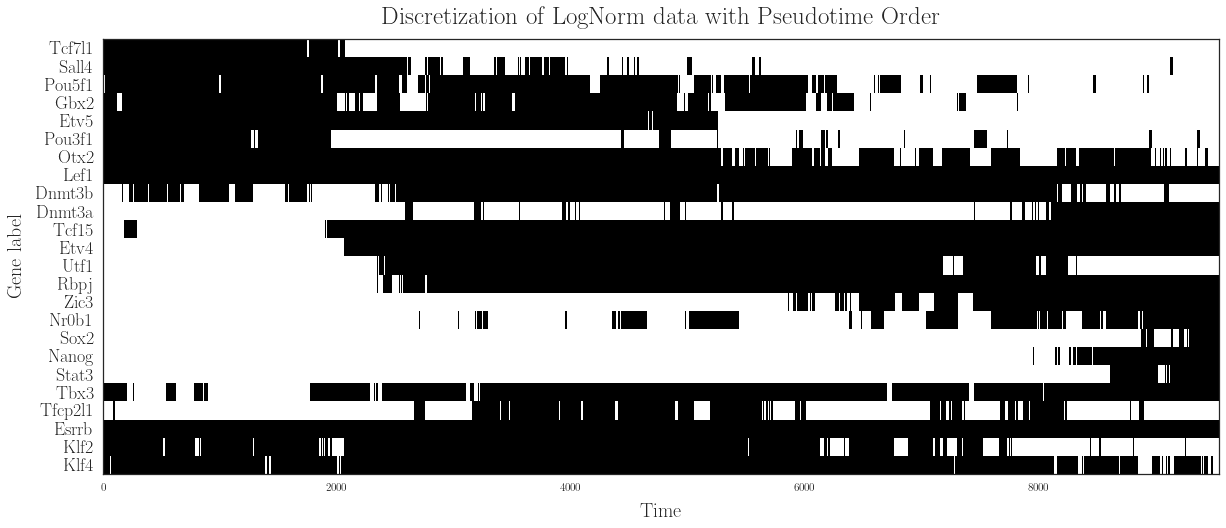

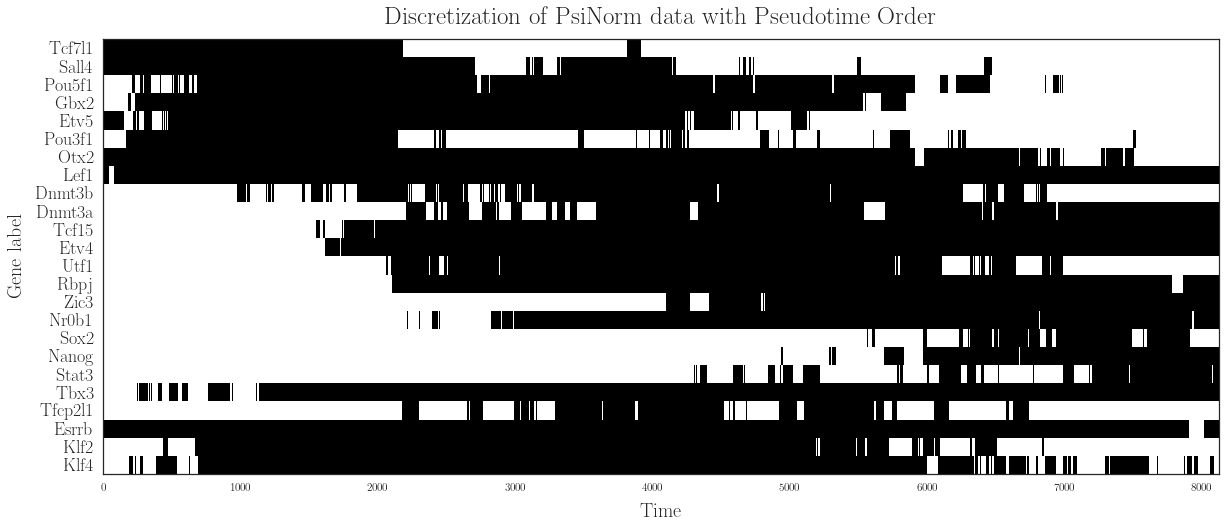

In [13]:
spins_df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()


spins_df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()



# Randomization

In [14]:
spins_df_lN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy")
spins_df_pN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins_RND50Test.npy")
 
Ntest = spins_df_lN_mb_pst_shuffle.shape[0] 

print(Ntest)



50


In [15]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_mb_pst_shuffle, Ntest))
    
    # zero expected if everithing is working fine

0.0
0.0


In [16]:
show = False
if show:
    for ii in range(0, Ntest, 60):
            fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show()    
            fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            

# Experimental Results

## Neighbours interactions

In [17]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed Correlations

In [18]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)


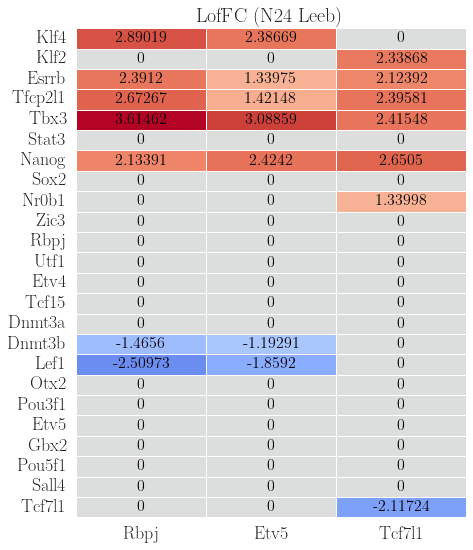

In [19]:
correlations_list = funcs_general.InteractionList(df_KO_N24_Leeb_cl, perc = 0)

fun_plotting.plot_log2FC(df_KO_N24_Leeb_cl, "LofFC (N24 Leeb)")

# Results
## ISNIG Model results

In [20]:
interaction_thr = 0.01


## Ising PST+MB

In [21]:
Ntrials = 150

today = "thr1_23_03_29" # "thr1_onlyPST" # or other data
data_type = "pst_mb"

# LOADING the data    
lN_arrays = np.load(path_data+'OUT_ISING/LogNORM/lN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
lN_matx_sel_true = lN_arrays['array_1']
lN_prec_sel_true = lN_arrays['array_2']
lN_int_val_true = lN_arrays['array_3']

pN_arrays = np.load(path_data+'OUT_ISING/PsiNORM/pN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
pN_matx_sel_true = pN_arrays['array_1']
pN_prec_sel_true = pN_arrays['array_2']
pN_int_val_true =  pN_arrays['array_3']


In [22]:
# load inferred data
lN_high_meanMatx = np.load(path_data + "OUT_ISING/LogNORM/LogNorm_InferredMatrix_"+today+".npy") #"OUT_ISING/LogNORM/LogNorm_InferredMatrix_thr1_onlyPST.npy")
lN_Mean_TP_frac  = np.load(path_data +  "OUT_ISING/LogNORM/LogNorm_TPfrac_"+today+".npy") #"OUT_ISING/LogNORM/LogNorm_TPfrac_thr1_onlyPST.npy")
lN_Mean_info_int = np.load(path_data +  "OUT_ISING/LogNORM/LogNorm_info_ints_"+today+".npy") #"OUT_ISING/LogNORM/LogNorm_info_ints_thr1_onlyPST.npy")

pN_high_meanMatx = np.load(path_data + "OUT_ISING/PsiNORM/PsiNorm_InferredMatrix_"+today+".npy")
pN_Mean_TP_frac  = np.load(path_data + "OUT_ISING/PsiNORM/PsiNorm_TPfrac_"+today+".npy")
pN_Mean_info_int = np.load(path_data + "OUT_ISING/PsiNORM/PsiNorm_info_ints_"+today+".npy")


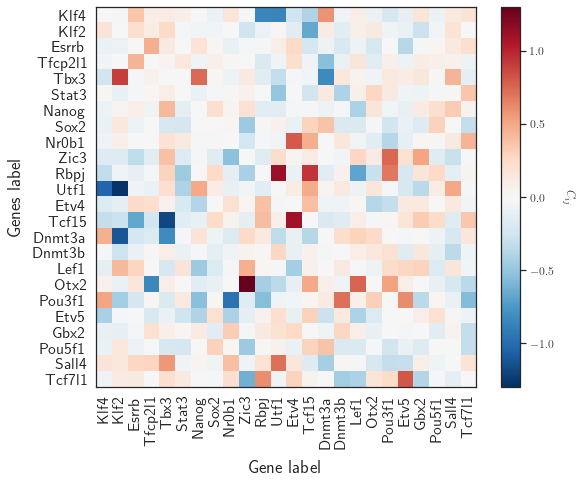

Min and Max values of J:  1.3011 -1.2723


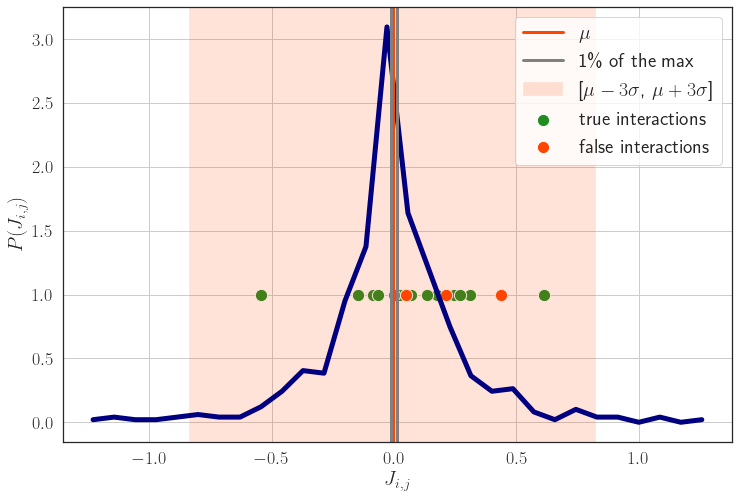

In [23]:
# Matrix of interactions and interactions distribution plots
# all interactions
na.intM_plot(lN_high_meanMatx)
print("Min and Max values of J: ", np.round(lN_high_meanMatx.max(),4), np.round(lN_high_meanMatx.min(),4))

# interactions above the threshold (decoment to see the plot)
# lN_high_meanMatx_thr = na.to_thr_matrix(lN_high_meanMatx, thr=interaction_thr)
# na.intM_plot(lN_high_meanMatx_thr)

# distribution of interactions
na.interactions_plot(lN_high_meanMatx, lN_Mean_info_int, thr = interaction_thr)


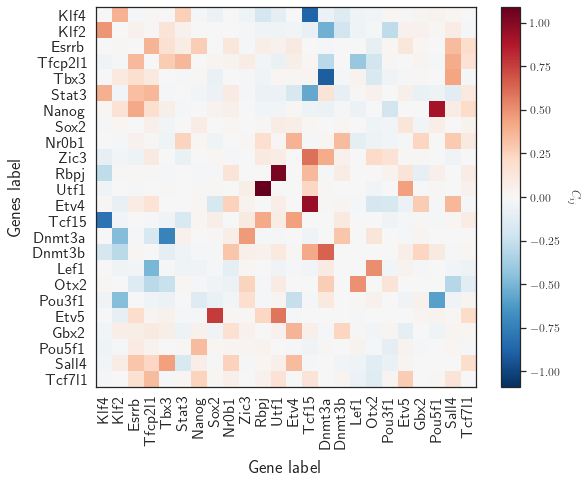

Min and Max values of J:  1.0913 -0.8997


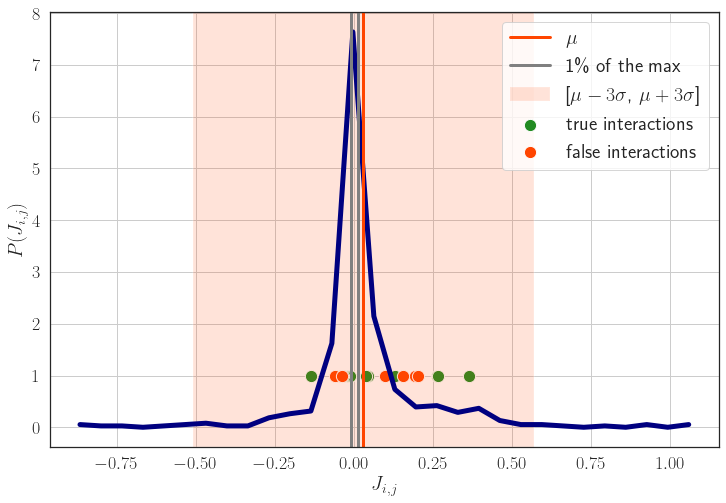

In [24]:
# Repeat the last code for PsiNorm data
na.intM_plot(pN_high_meanMatx)
print("Min and Max values of J: ", np.round(pN_high_meanMatx.max(),4), np.round(pN_high_meanMatx.min(),4))


# distribution of interactions
na.interactions_plot(pN_high_meanMatx, pN_Mean_info_int, thr = interaction_thr)

### ISING PST

In [25]:
# Ntrials = 150

# today = "thr1_23_03_15" # or other data
# data_type = "pst"

# # LOADING the data    
# lN_arrays_pst = np.load(path_data+'OUT_ISING/LogNORM/lN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
# lN_pst_matx_sel_true = lN_arrays_pst['array_1']
# lN_pst_prec_sel_true = lN_arrays_pst['array_2']
# lN_pst_int_val_true = lN_arrays_pst['array_3']

# pN_arrays_pst = np.load(path_data+'OUT_ISING/PsiNORM/pN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
# pN_pst_matx_sel_true = pN_arrays_pst['array_1']
# pN_pst_prec_sel_true = pN_arrays_pst['array_2']
# pN_pst_int_val_true =  pN_arrays_pst['array_3']


## PEARSON's Correlations


In [26]:
df_list = [df_bulk, df_raw, df_lN, df_pN, df_raw_mb, df_lN_mb, df_pN_mb, df_lN_mb_pst, df_pN_mb_pst]
df_name = ["Bulk data", "Raw data", "LogNorm data", "PsiNorm data", "Raw + MB, size "+str(mb_wind), "LogNorm + MB, size "+str(mb_wind), "PsiNorm + MB, size "+str(mb_wind), "LogNorm + PST + MB", "PsiNorm + PST + MB"]


In [27]:
# Evaluate the number of known interaction for all the cm matrices in a for
known_int_frac = np.zeros(len(df_list))
for i in range(len(df_list)):
    # set the threshold for the MaxEnt matrix
    if i == 0:
        interaction_thr_Pearson = 0.54
    else:
        interaction_thr_Pearson = 0.03
        
    cm = np.load(path_data + "OUT_Pearson/CM_" + df_name[i] + ".npy")
    known_int_frac[i] = funcs_general.TP_plot(TPtrial_list, cm, genes_order, data_type=df_name[i], inferred_int_thr = interaction_thr_Pearson, figplot=False, verbose=False, nbin=30, Norm = False)[0]
    # print the number of known interactions
    print(f"Number of known interactions for {df_name[i]}: {known_int_frac[i]:.2f}")

Number of known interactions for Bulk data: 0.39
Number of known interactions for Raw data: 0.39
Number of known interactions for LogNorm data: 0.44
Number of known interactions for PsiNorm data: 0.39
Number of known interactions for Raw + MB, size 150: 0.61
Number of known interactions for LogNorm + MB, size 150: 0.67
Number of known interactions for PsiNorm + MB, size 150: 0.67
Number of known interactions for LogNorm + PST + MB: 0.67
Number of known interactions for PsiNorm + PST + MB: 0.67


## MaxEnt Results

In [28]:
# Evaluate the number of known interaction for all the cm matrices in a for
known_int_frac = np.zeros(len(df_list))
for i in range(len(df_list)):
    if i == 0:
        interaction_thr_ME = 6.06
    else:
        interaction_thr_ME = 0.03
    cm = np.load(path_data + "OUT_MaxEnt/ME_" + df_name[i] + ".npy")
    known_int_frac[i] = funcs_general.TP_plot(TPtrial_list, cm, genes_order, data_type=df_name[i], inferred_int_thr = interaction_thr_ME, figplot=False, verbose=False, nbin=30, Norm = False)[0]
    # print the number of known interactions
    print(f"Number of known interactions for {df_name[i]}: {known_int_frac[i]:.2f}")

Number of known interactions for Bulk data: 0.50
Number of known interactions for Raw data: 0.33
Number of known interactions for LogNorm data: 0.33
Number of known interactions for PsiNorm data: 0.33
Number of known interactions for Raw + MB, size 150: 0.44
Number of known interactions for LogNorm + MB, size 150: 0.44
Number of known interactions for PsiNorm + MB, size 150: 0.44
Number of known interactions for LogNorm + PST + MB: 0.72
Number of known interactions for PsiNorm + PST + MB: 0.33


## SCODE Results

# Data generation

In [29]:
params = {"LAMBDA" : [0.01, 0.02, 0.03,0.04, 0.05, 0.07, 0.09],
          "lr"     : [0.8, 0.7, 0.6, 0.5, 0.4, 0.3],
          "drop"   : [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "edrop"  : [15, 20, 25, 30, 35],
          "opt"    : ['MOMENTUM','NADAM'],
          "MOM"    : [0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "reg"    : ['L1'],
          "Nepochs": [500, 700, 800, 900, 1200]}


In [30]:
np.random.seed(20961)    #(10101959)#(20091961)
Ntrials = 150

for ii in range(Ntrials):
    par_sel = {}
    for jj in params.keys():
        par_sel[jj] = np.random.choice(params[jj])
    if ii==31: #31 for PST MB lognorm
        print("\nParams for LogNorm\n", par_sel)
    if ii==147: #31 for PST MB lognorm
        print("\nParams for  PsiNorm\n", par_sel)



Params for LogNorm
 {'LAMBDA': 0.04, 'lr': 0.4, 'drop': 0.85, 'edrop': 15, 'opt': 'MOMENTUM', 'MOM': 0.99, 'reg': 'L1', 'Nepochs': 500}

Params for  PsiNorm
 {'LAMBDA': 0.03, 'lr': 0.6, 'drop': 0.99, 'edrop': 15, 'opt': 'MOMENTUM', 'MOM': 0.95, 'reg': 'L1', 'Nepochs': 900}


## LogNorm

/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/ml_wrapper.py:34: RuntimeWarning: divide by zero encountered in arctanh
  self.h = np.arctanh(np.mean(x, axis = 1))
/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:171: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  return 1/delta_t*(np.dot(spins[:,1:], spins[:,:-1].T)/Nsteps - cov)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:269: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  gJ = nb_dJ(cov, dot_cov, spins, new_h, new_J, theta)


0 	 0.999895 	 1.0 	 0.4126 	 0.384 	 -0.5504479786551469
100 	 0.339555 	 0.233825 	 0.2829 	 0.0621 	 -4.153041676518795
200 	 0.331083 	 0.301216 	 0.1062 	 0.0478 	 -3.1320863957484186
300 	 0.241861 	 0.190668 	 0.051 	 0.0332 	 -2.6184842870878797
400 	 0.21405 	 0.214354 	 0.0235 	 0.0127 	 -2.351544290862687


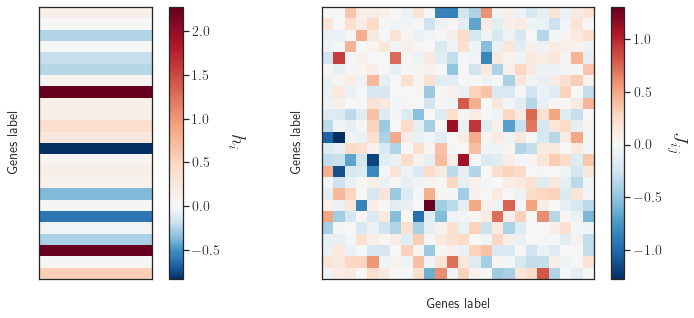


RESULTS for scRNA-seq PST MB with ISING

TP fraction: 0.78

Interaction values:
 [ 0.069  0.175 -0.085 -0.146 -0.542  0.023  0.137  0.312  0.247  0.214
 -0.001  0.048  0.438 -0.063 -0.147 -0.148  0.269  0.614]

TP ints values:
 [ 0.069  0.175 -0.085 -0.146 -0.542  0.023  0.137  0.312  0.247  0.
 -0.     0.     0.    -0.063 -0.147 -0.148  0.269  0.614]


In [31]:
# initialize the reconstruction
Nepochs = 500
LAMBDA = 0.04
lr = 0.4
drop = 0.85
edrop = 15


model_lN_best = asynch_reconstruction(np.array(spins_df_lN_mb_pst), delta_t = 1, LAMBDA = LAMBDA, opt = 'MOMENTUM', MOM=0.99, reg = 'L1')

# reconstruct the model 
np.random.seed(1234)
model_lN_best.reconstruct(np.array(spins_df_lN_mb_pst), Nepochs = Nepochs, start_lr = lr, drop = drop, edrop = edrop)

# compute the TP fraction and the info of the inferred interactions
lN_rec_tp_val, lN_rec_info_int, lN_rec_matx = funcs_general.TP_plot(TPtrial_list, model_lN_best.J, genes_order, 
                                                   inferred_int_thr=interaction_thr, Norm_Matx = False,
                                                   data_type="scRNA-seq PST MB with ISING",
                                                   figplot=False, verbose=True, nbin=30, Norm=True)


### Generating Data

/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:135: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  slist[:,idx+1] = asynch_glauber_dynamics(h, J, slist[:,idx], delta_t, gamma)


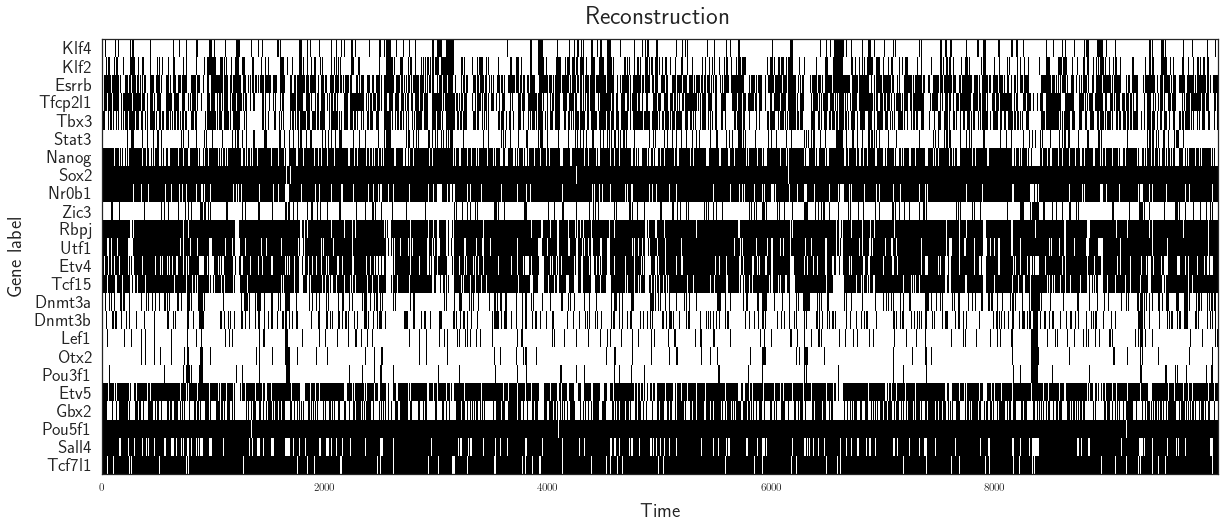

In [32]:
Ntrials = 50
Ntimes = 10000 #df_pN_mb_pst.shape[1]
spins_new_lN = np.zeros((df_lN_mb_pst.shape[0], Ntimes, Ntrials))

for ii in range(Ntrials):
    np.random.seed(1234)
    spins_new_lN[:,:,ii] = model_lN_best.generate_samples(seed=ii*2, t_size=Ntimes)

fun_plotting.raster_plot(spins_new_lN[:,:,0], 'Reconstruction', 1, genes_order)
plt.show()


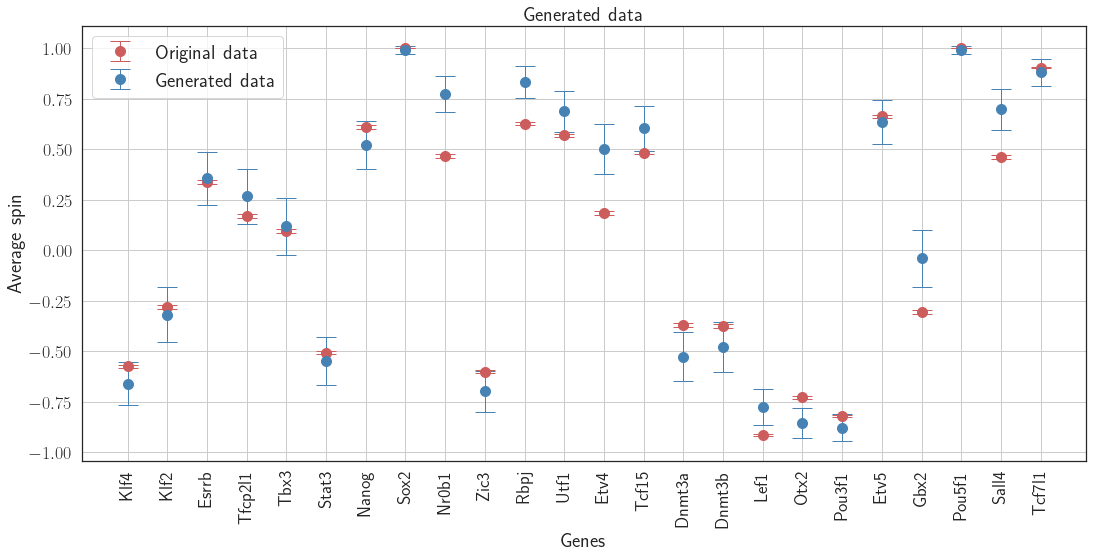

In [33]:
# plot the average activity of the genes  
fig, ax = plt.subplots(1,1, figsize=(18,8))
avg_activity_lN, avg_activity_std_lN         = funcs_ko.plot_activity(spins_df_lN_mb_pst, genes_order, "Original data", "indianred", ax)
avg_activity_lN_sim, avg_activity_std_lN_sim = funcs_ko.plot_activity_simulated(spins_new_lN, genes_order, "Generated data", "steelblue", ax)
plt.xticks(rotation=90, fontsize=18)
plt.yticks( fontsize=18)
plt.show()

fraction of significant 0.9583333333333334


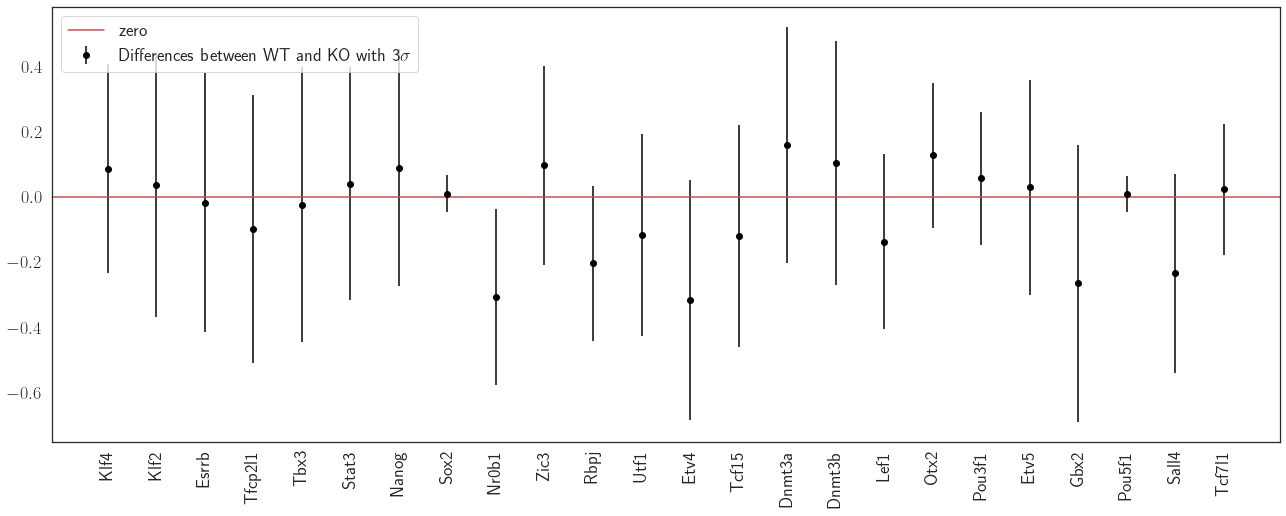

In [34]:
# number of sigma considered
N_sigma = 3

# compute the difference between the original and simulated spins values
diff_activity_lN = np.zeros(len(avg_activity_lN))
diff_activity_lN_std = np.zeros(len(avg_activity_lN))
count = 0
for i in range(len(avg_activity_lN)):
    diff_activity_lN[i] = (avg_activity_lN[i] - avg_activity_lN_sim[i])
    diff_activity_lN_std[i] = np.sqrt(avg_activity_std_lN[i]**2 + avg_activity_std_lN_sim[i]**2)
    if np.abs(diff_activity_lN[i]) < N_sigma * diff_activity_lN_std[i]:
        # print("gene: ", genes_order[i], " has a difference of: ", diff_activity_lN[i], " std: ", N_sigma * diff_activity_lN_std[i])
        count += 1

plt.figure(figsize=(22,8))
plt.errorbar(genes_order, diff_activity_lN, yerr=N_sigma*diff_activity_lN_std, fmt='o', color='black', label = "Differences between WT and KO with "+str(N_sigma)+"$\sigma$")
plt.axhline(y=0, color='r', linestyle='-', label= " zero")
plt.legend(fontsize=18, loc="upper left")
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)

print("fraction of significant", count/len(genes_order))

### Correlation Matrices

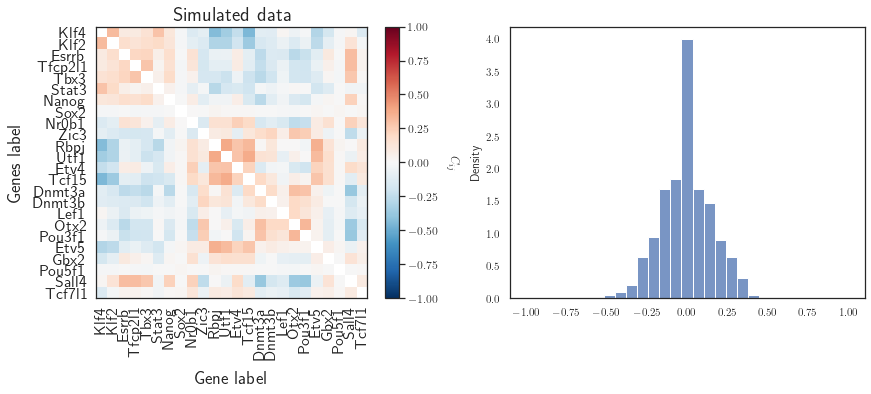

[]


In [35]:
cm_sim_lN = np.zeros((spins_new_lN.shape[0], spins_new_lN.shape[0], spins_new_lN.shape[2]))
for ii in range(spins_new_lN.shape[2]):
    cm_sim_lN[:,:, ii] = np.corrcoef(spins_new_lN[:,:,ii])
cm_sim_lN_mean = np.mean(cm_sim_lN, axis=2)

bins = np.linspace(-1, 1, 30)

cm_sim_lN_mean_noDiag = cm_sim_lN_mean.copy()
np.fill_diagonal(cm_sim_lN_mean_noDiag, float("Nan")) # remove the diagonal
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim_lN_mean_noDiag, fig, ax[0], genes_order, "Simulated data", fix=True)
sns.histplot(np.ndarray.flatten(cm_sim_lN_mean_noDiag), bins=bins,  ax=ax[1], stat="density")
plt.show()

# find rows and columns that contains all nan
row_nan_lN_sim = np.where(np.isnan(cm_sim_lN_mean).all(axis=1))[0]
col_nan_lN_sim = np.where(np.isnan(cm_sim_lN_mean).all(axis=0))[0]
# find union of the two arrays
idx_nan_lN_sim = np.union1d(row_nan_lN_sim, col_nan_lN_sim)
print(idx_nan_lN_sim)

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


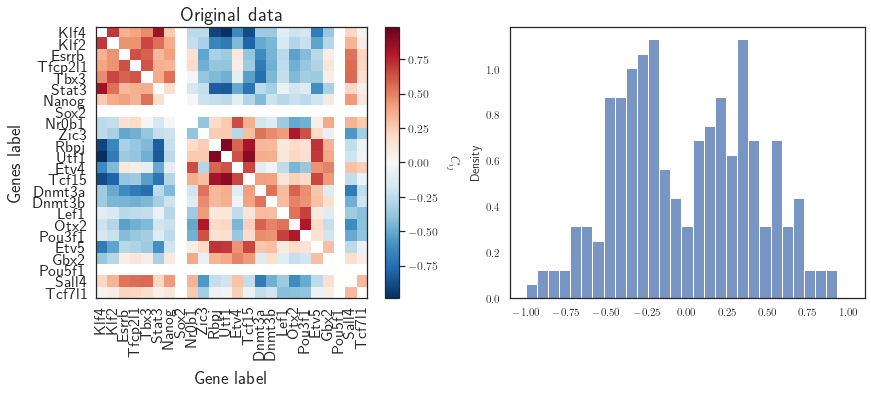

[ 7 21]


In [36]:
cm_original_lN = np.corrcoef(spins_df_lN_mb_pst)

bins = np.linspace(-1, 1, 30)
cm_original_lN_noDiag = cm_original_lN.copy()
np.fill_diagonal(cm_original_lN_noDiag, float("Nan")) # remove the diagonal
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_original_lN_noDiag, fig, ax[0], genes_order, "Original data")
sns.histplot(np.ndarray.flatten(cm_original_lN_noDiag), bins=bins,  ax=ax[1], stat="density")
plt.show()

# find rows and columns that contains all nan
row_nan_lN = np.where(np.isnan(cm_original_lN).all(axis=1))[0]
col_nan_lN = np.where(np.isnan(cm_original_lN).all(axis=0))[0]
# find union of the two arrays
idx_nan_lN = np.union1d(row_nan_lN, col_nan_lN)
print(idx_nan_lN)

# unify the list of indices of simulated and original matxs
idx_nan_lN = np.union1d(idx_nan_lN, idx_nan_lN_sim)


(50, 24, 24)


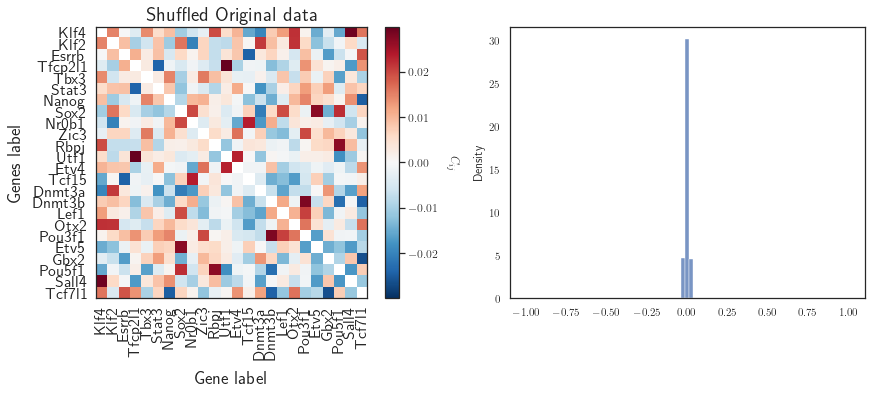

In [37]:
# random correlation matrix: shuffle the rows and columns of the original matrix Ntrials times
corr_matxs_rnd_lN = np.array([np.corrcoef(spins_df_lN_mb_pst_shuffle[i,:,:]) for i in range(Ntest)])
print(corr_matxs_rnd_lN.shape)

corr_matxs_rnd_lN_noDiag = corr_matxs_rnd_lN[10,:,:].copy()
np.fill_diagonal(corr_matxs_rnd_lN_noDiag, float("Nan")) # remove the diagonal

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(corr_matxs_rnd_lN_noDiag, fig, ax[0], genes_order, "Shuffled Original data")

bins=np.linspace(np.nanmin(corr_matxs_rnd_lN_noDiag), np.nanmax(corr_matxs_rnd_lN_noDiag), 15)
bins=np.linspace(-1, 1, 80)
sns.histplot(np.ndarray.flatten(corr_matxs_rnd_lN_noDiag), bins=bins,  ax=ax[1], stat="density")
plt.show()

In [38]:
cm_orig_lN_red = cm_original_lN.copy() # original data
cm_sim_lN_red = cm_sim_lN.copy() # simulated data

# remove the rows and columns that contains all nan
corr_matx_rnd_lN_red = corr_matxs_rnd_lN.copy() 
idx_nan_lN_run = idx_nan_lN.copy()
for ii in range(len(idx_nan_lN_run)):
    # remove the rows and columns that contains all nan
    if ii>0: # update the index of the rows and columns to be removed
        idx_nan_lN_run[ii]=idx_nan_lN_run[ii]-1
    # original data
    cm_orig_lN_red = np.delete(cm_orig_lN_red, idx_nan_lN_run[ii], axis=0)
    cm_orig_lN_red = np.delete(cm_orig_lN_red, idx_nan_lN_run[ii], axis=1)   
    #original data randomized (the shuffle is done Ntrials times)    
    corr_matx_rnd_lN_red = np.delete(corr_matx_rnd_lN_red, idx_nan_lN_run[ii], axis=1)
    corr_matx_rnd_lN_red = np.delete(corr_matx_rnd_lN_red, idx_nan_lN_run[ii], axis=2)
    # simulated data
    cm_sim_lN_red = np.delete(cm_sim_lN_red, idx_nan_lN_run[ii], axis=0)
    cm_sim_lN_red = np.delete(cm_sim_lN_red, idx_nan_lN_run[ii], axis=1)   
    
genes_selected = np.delete(genes_order, idx_nan_lN)
print("deleted: ", genes_order[idx_nan_lN])

# check if there are nans
if len(np.argwhere(np.isnan(cm_orig_lN_red))):
    print("there are nans in cm_orig_lN_red")


deleted:  ['Sox2' 'Pou5f1']


### Distance

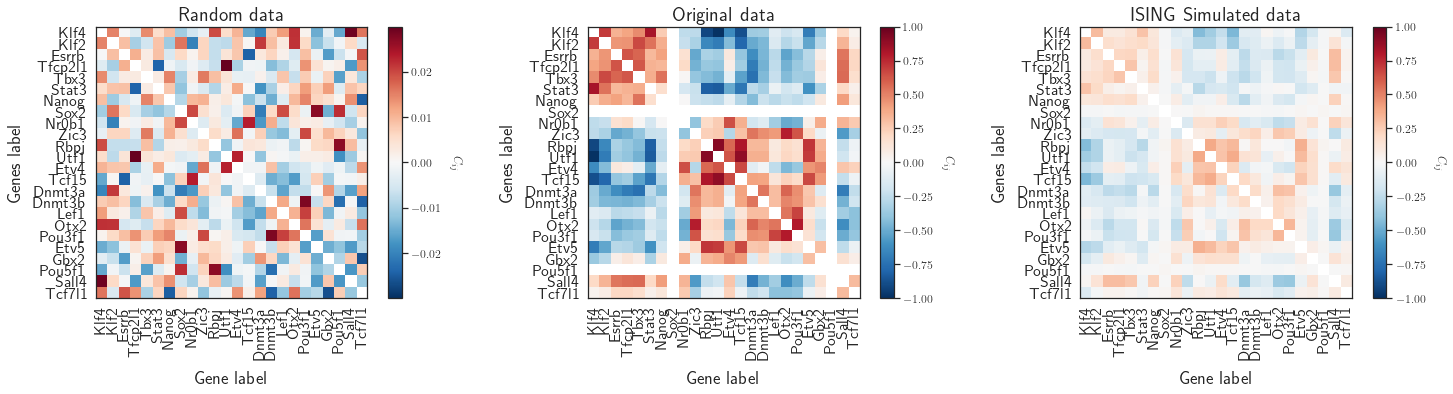

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
figfunc.plotmat(corr_matxs_rnd_lN_noDiag, fig, ax[0], genes_order, "Random data")
figfunc.plotmat(cm_original_lN_noDiag, fig, ax[1], genes_order, "Original data", fix = True)
figfunc.plotmat(cm_sim_lN_mean_noDiag, fig, ax[2], genes_order, "ISING Simulated data", fix = True)
plt.show()



In [40]:
# compute the noise for the distance between matrixes
noise_dist = [funcs_ko.sum_squared_abs_diff(cm_orig_lN_red, corr_matx_rnd_lN_red[i,:,:]) for i in range(50)]
noise_dist = np.mean(noise_dist)
# print(noise_dist)

# compute the  weighted distance between the original and simulated matrixes
result_IO = [funcs_ko.sum_squared_abs_diff(cm_orig_lN_red, cm_sim_lN_red[:,:,i]) for i in range(Ntrials)]
result_IO = np.mean(result_IO)/ noise_dist # normalize by the noise
print(f"Distance between the original and simulated matrixes: {result_IO.round(2)}")


Distance between the original and simulated matrixes: 0.63


### Clustering on Simulated Data

In [41]:
# trial = spins_new_lN[:,:,:].reshape(spins_new_lN.shape[0], spins_new_lN.shape[1]*spins_new_lN.shape[2])
# trial = trial.T
# trial.shape

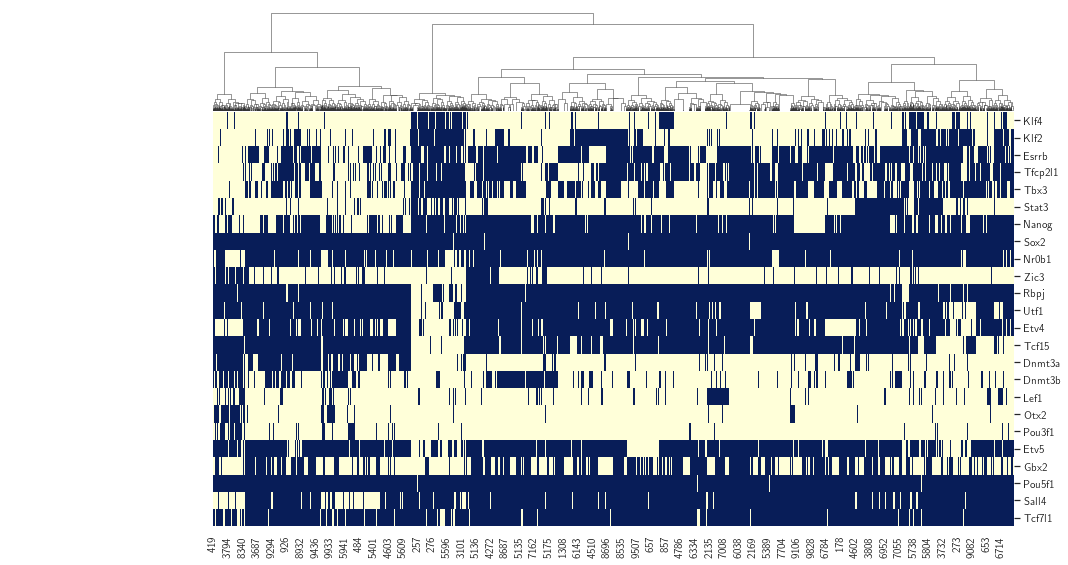

In [42]:
# Perform linkage on your numpy array
jj=0
Z = scipy.cluster.hierarchy.linkage(spins_new_lN[:,:,jj].T, method='ward')

# Note: we are showing just one simulated dataset, but you can do the same for all of them

# Plot the dendrogram and heatmap
sns.clustermap(spins_new_lN[:,:, jj], col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=False, figsize=(15,8), row_cluster=False )
plt.xticks([])
plt.yticks([])
plt.show()


### Clustering on Original Data

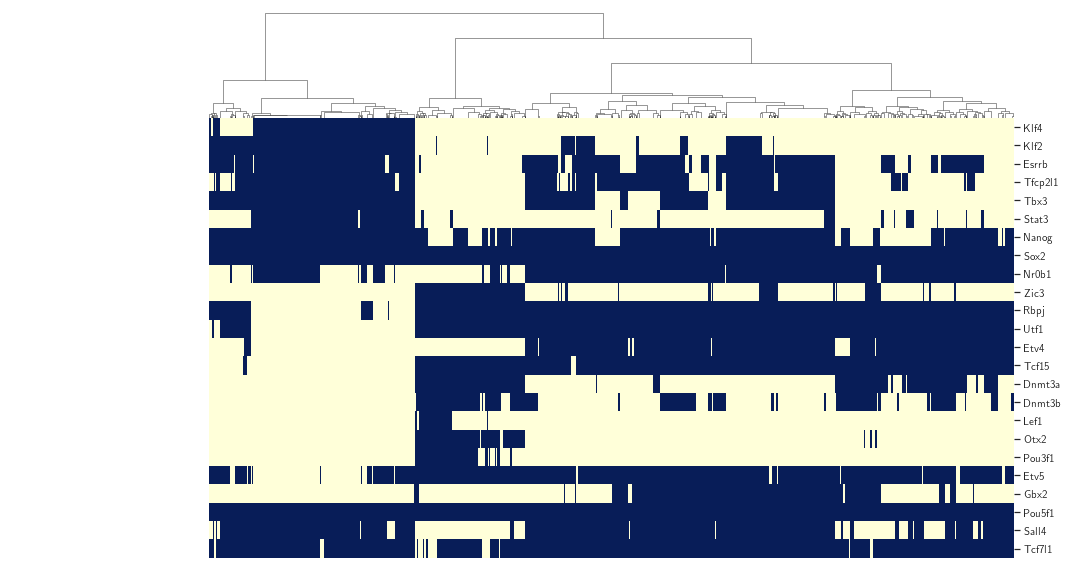

In [43]:
# Perform linkage on your numpy array
Z = scipy.cluster.hierarchy.linkage(spins_df_lN_mb_pst.T, method='ward')

# Plot the dendrogram and heatmap
sns.clustermap(spins_df_lN_mb_pst, col_linkage=Z, cmap='YlGnBu',
               yticklabels=genes_order, xticklabels=[],
               cbar=False, figsize=(15,8), row_cluster=False )

plt.xticks([])
plt.yticks([])

plt.show()

## PsiNorm

Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
0 	 0.964919 	 0.991136 	 0.5811 	 0.5767 	 -0.5353190542391589
100 	 0.162011 	 0.135921 	 0.3117 	 0.0892 	 -1.5777041946090808
200 	 0.323287 	 0.323356 	 0.204 	 0.1114 	 -1.4776633711445302
300 	 0.234006 	 0.185782 	 0.0708 	 0.027 	 -1.4487074707621825
400 	 0.163408 	 0.164035 	 0.079 	 0.0235 	 -1.4456851955098475
500 	 0.121376 	 0.122625 	 0.0516 	 0.0236 	 -1.423953858376333
600 	 0.074191 	 0.044772 	 0.045 	 0.0298 	 -1.4463964740987436
700 	 0.106101 	 0.106756 	 0.0471 	 0.0353 	 -1.4512194396870746
800 	 0.067431 	 0.044323 	 0.0398 	 0.0199 	 -1.4363900187622274


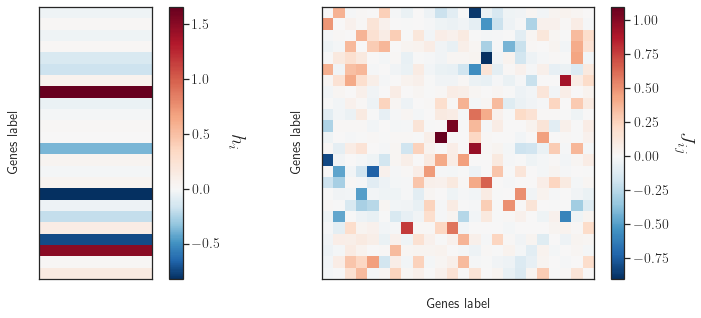


RESULTS for scRNA-seq PST MB with ISING

TP fraction: 0.67

Interaction values:
 [ 0.263  0.265 -0.049 -0.023 -0.137 -0.059  0.365  0.043  0.131  0.194
 -0.012  0.203  0.097  0.154 -0.03  -0.034  0.039 -0.037]

TP ints values:
 [ 0.263  0.265 -0.049 -0.023 -0.137 -0.     0.365  0.043  0.131  0.
 -0.012  0.     0.     0.    -0.03  -0.034  0.039 -0.   ]


In [44]:
# initialize the reconstruction
Nepochs = 900
LAMBDA = 0.03
lr = 0.6
drop = 0.99
edrop = 15

np.random.seed(1234)
model_pN_best = asynch_reconstruction(np.array(spins_df_pN_mb_pst), delta_t = 1, LAMBDA = LAMBDA, opt = 'MOMENTUM', MOM=0.95, reg = 'L1')

# reconstruct the model 
np.random.seed(1234)
model_pN_best.reconstruct(np.array(spins_df_pN_mb_pst), Nepochs = Nepochs, start_lr = lr, drop = drop, edrop = edrop)

pN_rec_tp_val, pN_rec_info_int, pN_rec_matx = funcs_general.TP_plot(TPtrial_list, model_pN_best.J, genes_order, 
                                                   inferred_int_thr=interaction_thr, Norm_Matx = False,
                                                   data_type="scRNA-seq PST MB with ISING",
                                                   figplot=False, verbose=True, nbin=30, Norm=True)



### Generating Data

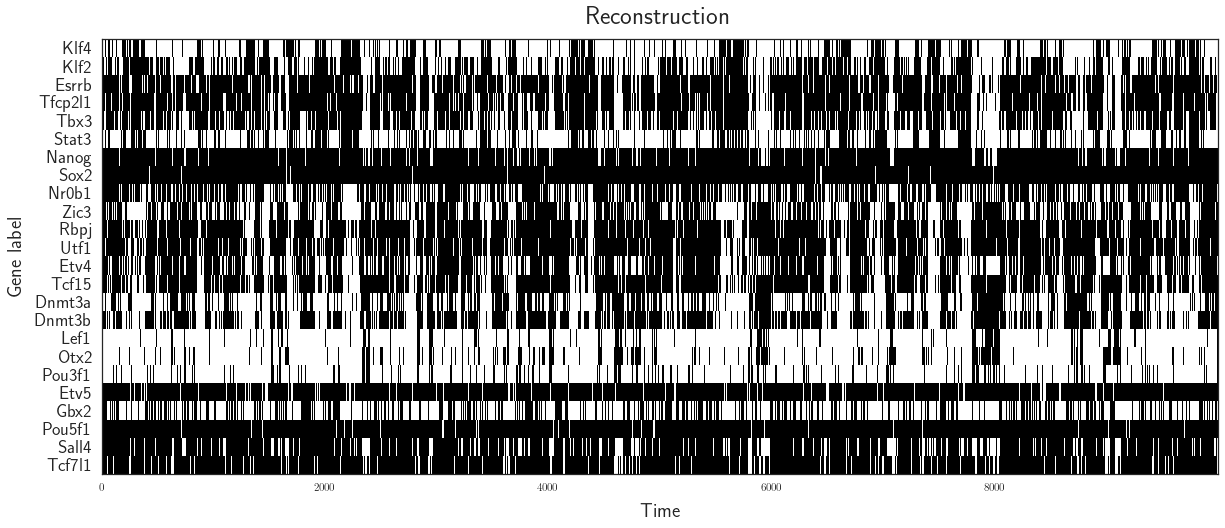

In [45]:
Ntrials = 50
Ntimes = 10000 #df_pN_mb_pst.shape[1]
spins_new_pN = np.zeros((df_pN_mb_pst.shape[0], Ntimes, Ntrials))


for ii in range(Ntrials):
    np.random.seed(1234)
    spins_new_pN[:,:,ii] = model_pN_best.generate_samples(seed=ii*2, t_size = 10000)

fun_plotting.raster_plot(spins_new_pN[:,:,0], 'Reconstruction', 1, genes_order)
plt.show()



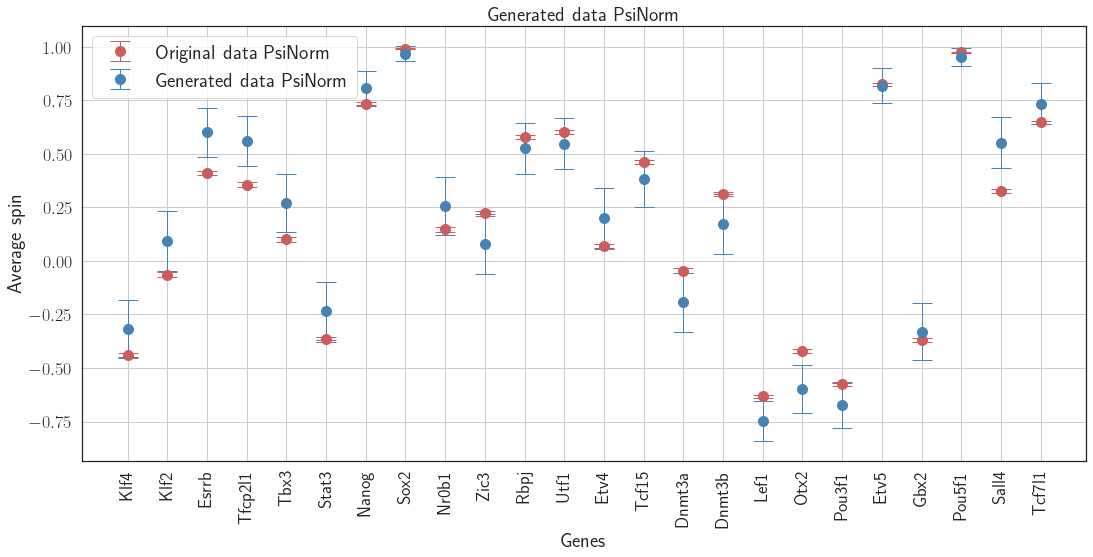

In [46]:
# plot the average activity of the genes  
fig, ax = plt.subplots(1,1, figsize=(18,8))
avg_activity_pN, avg_activity_std_pN         = funcs_ko.plot_activity(spins_df_pN_mb_pst, genes_order, "Original data PsiNorm", "indianred", ax)
avg_activity_pN_sim, avg_activity_std_pN_sim = funcs_ko.plot_activity_simulated(spins_new_pN, genes_order, "Generated data PsiNorm", "steelblue", ax)
plt.xticks(rotation=90, fontsize=18)
plt.yticks( fontsize=18)
plt.show()

fraction of significant 1.0


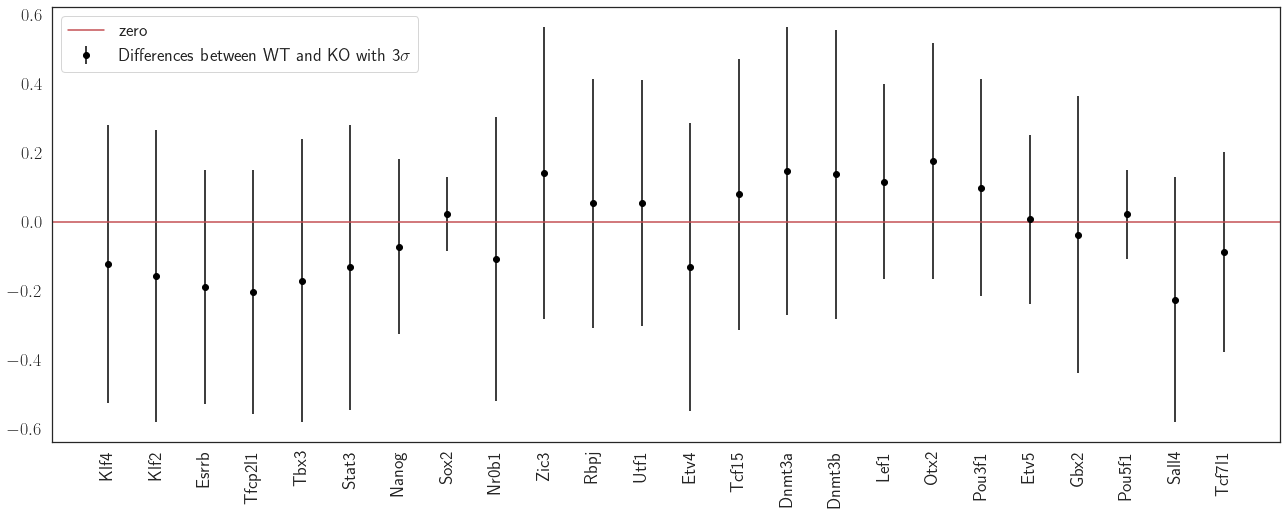

In [47]:
# number of sigma considered
N_sigma = 3

# compute the difference between the original and simulated spins values
diff_activity_pN = np.zeros(len(avg_activity_pN))
diff_activity_pN_std = np.zeros(len(avg_activity_pN))
count = 0
for i in range(len(avg_activity_pN)):
    diff_activity_pN[i] = (avg_activity_pN[i] - avg_activity_pN_sim[i])
    diff_activity_pN_std[i] = np.sqrt(avg_activity_std_pN[i]**2 + avg_activity_std_pN_sim[i]**2)
    if np.abs(diff_activity_pN[i]) < N_sigma * diff_activity_pN_std[i]:
        # print("gene: ", genes_order[i], " has a difference of: ", diff_activity_pN[i], " std: ", N_sigma * diff_activity_pN_std[i])
        count += 1

plt.figure(figsize=(22,8))
plt.errorbar(genes_order, diff_activity_pN, yerr=N_sigma*diff_activity_pN_std, fmt='o', color='black', label = "Differences between WT and KO with "+str(N_sigma)+"$\sigma$")
plt.axhline(y=0, color='r', linestyle='-', label= " zero")
plt.legend(fontsize=18, loc="upper left")
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)

print("fraction of significant", count/len(genes_order))

### Correlation Matrices

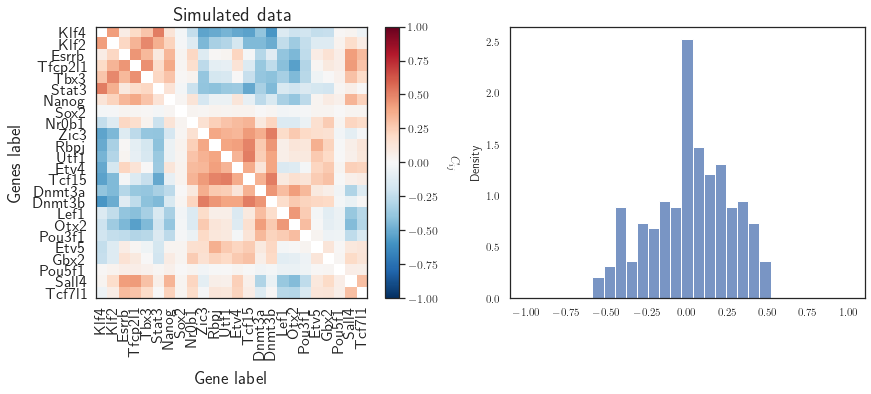

[]


In [48]:
cm_sim_pN = np.zeros((spins_new_pN.shape[0], spins_new_pN.shape[0], spins_new_pN.shape[2]))
for ii in range(spins_new_pN.shape[2]):
    cm_sim_pN[:,:, ii] = np.corrcoef(spins_new_pN[:,:,ii])
cm_sim_pN_mean = np.mean(cm_sim_pN, axis=2)

bins = np.linspace(-1, 1, 30)

cm_sim_pN_mean_noDiag = cm_sim_pN_mean.copy()
np.fill_diagonal(cm_sim_pN_mean_noDiag, float("Nan")) # remove the diagonal
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim_pN_mean_noDiag, fig, ax[0], genes_order, "Simulated data", fix=True)
sns.histplot(np.ndarray.flatten(cm_sim_pN_mean_noDiag), bins=bins,  ax=ax[1], stat="density")
plt.show()

# find rows and columns that contains all nan
row_nan_pN_sim = np.where(np.isnan(cm_sim_pN_mean).all(axis=1))[0]
col_nan_pN_sim = np.where(np.isnan(cm_sim_pN_mean).all(axis=0))[0]
# find union of the two arrays
idx_nan_pN_sim = np.union1d(row_nan_pN_sim, col_nan_pN_sim)
print(idx_nan_pN_sim)

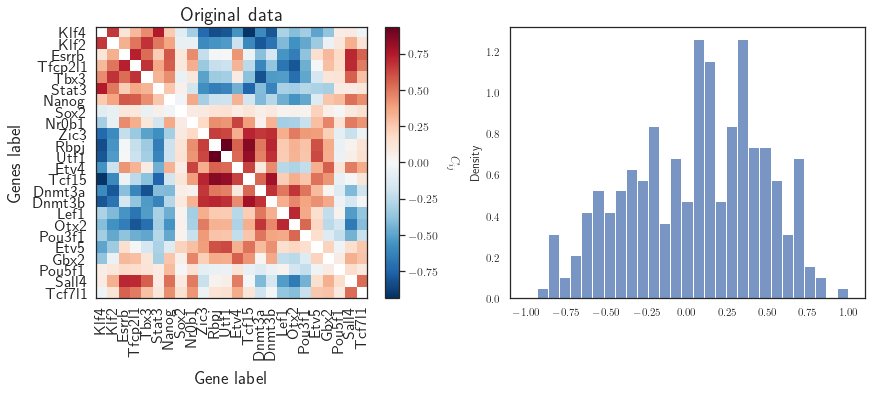

[]


In [49]:
cm_original_pN = np.corrcoef(spins_df_pN_mb_pst)

bins = np.linspace(-1, 1, 30)
cm_original_pN_noDiag = cm_original_pN.copy()
np.fill_diagonal(cm_original_pN_noDiag, float("Nan")) # remove the diagonal
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_original_pN_noDiag, fig, ax[0], genes_order, "Original data")
sns.histplot(np.ndarray.flatten(cm_original_pN_noDiag), bins=bins,  ax=ax[1], stat="density")
plt.show()

# find rows and columns that contains all nan
row_nan_pN = np.where(np.isnan(cm_original_pN).all(axis=1))[0]
col_nan_pN = np.where(np.isnan(cm_original_pN).all(axis=0))[0]
# find union of the two arrays
idx_nan_pN = np.union1d(row_nan_pN, col_nan_pN)
print(idx_nan_pN)

# unify the list of indices of simulated and original matxs
idx_nan_pN = np.union1d(idx_nan_pN, idx_nan_pN_sim)


(50, 24, 24)


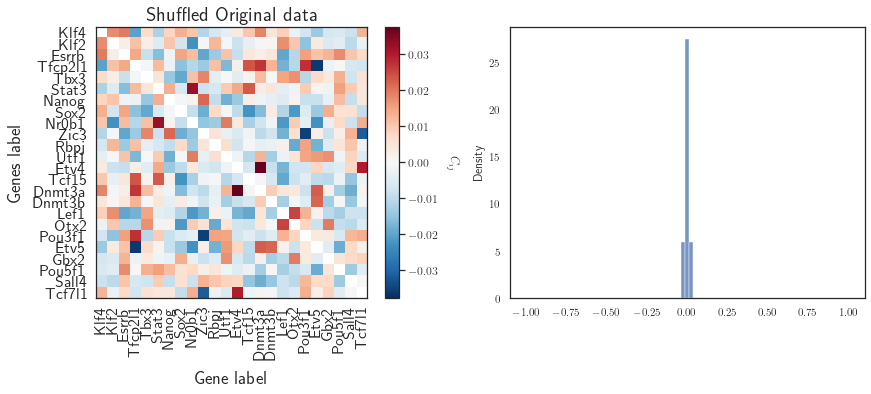

In [50]:
# random correlation matrix: shuffle the rows and columns of the original matrix Ntrials times
corr_matxs_rnd_pN = np.array([np.corrcoef(spins_df_pN_mb_pst_shuffle[i,:,:]) for i in range(Ntest)])
print(corr_matxs_rnd_pN.shape)

corr_matxs_rnd_pN_noDiag = corr_matxs_rnd_pN[10,:,:].copy()
np.fill_diagonal(corr_matxs_rnd_pN_noDiag, float("Nan")) # remove the diagonal

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(corr_matxs_rnd_pN_noDiag, fig, ax[0], genes_order, "Shuffled Original data")

bins=np.linspace(np.nanmin(corr_matxs_rnd_pN_noDiag), np.nanmax(corr_matxs_rnd_pN_noDiag), 15)
bins=np.linspace(-1, 1, 80)
sns.histplot(np.ndarray.flatten(corr_matxs_rnd_pN_noDiag), bins=bins,  ax=ax[1], stat="density")
plt.show()

In [51]:
cm_orig_pN_red = cm_original_pN.copy() # original data
cm_sim_pN_red = cm_sim_pN.copy() # simulated data

# remove the rows and columns that contains all nan
corr_matx_rnd_pN_red = corr_matxs_rnd_pN.copy() 
idx_nan_pN_run = idx_nan_pN.copy()
for ii in range(len(idx_nan_pN_run)):
    # remove the rows and columns that contains all nan
    if ii>0: # update the index of the rows and columns to be removed
        idx_nan_pN_run[ii]=idx_nan_pN_run[ii]-1
    # original data
    cm_orig_pN_red = np.delete(cm_orig_pN_red, idx_nan_pN_run[ii], axis=0)
    cm_orig_pN_red = np.delete(cm_orig_pN_red, idx_nan_pN_run[ii], axis=1)   
    #original data randomized (the shuffle is done Ntrials times)    
    corr_matx_rnd_pN_red = np.delete(corr_matx_rnd_pN_red, idx_nan_pN_run[ii], axis=1)
    corr_matx_rnd_pN_red = np.delete(corr_matx_rnd_pN_red, idx_nan_pN_run[ii], axis=2)
    # simulated data
    cm_sim_pN_red = np.delete(cm_sim_pN_red, idx_nan_pN_run[ii], axis=0)
    cm_sim_pN_red = np.delete(cm_sim_pN_red, idx_nan_pN_run[ii], axis=1)   
    
genes_selected = np.delete(genes_order, idx_nan_pN)
print("deleted: ", genes_order[idx_nan_pN])

# check if there are nans
if len(np.argwhere(np.isnan(cm_orig_pN_red))):
    print("there are nans in cm_orig_pN_red")


deleted:  []


### Distance

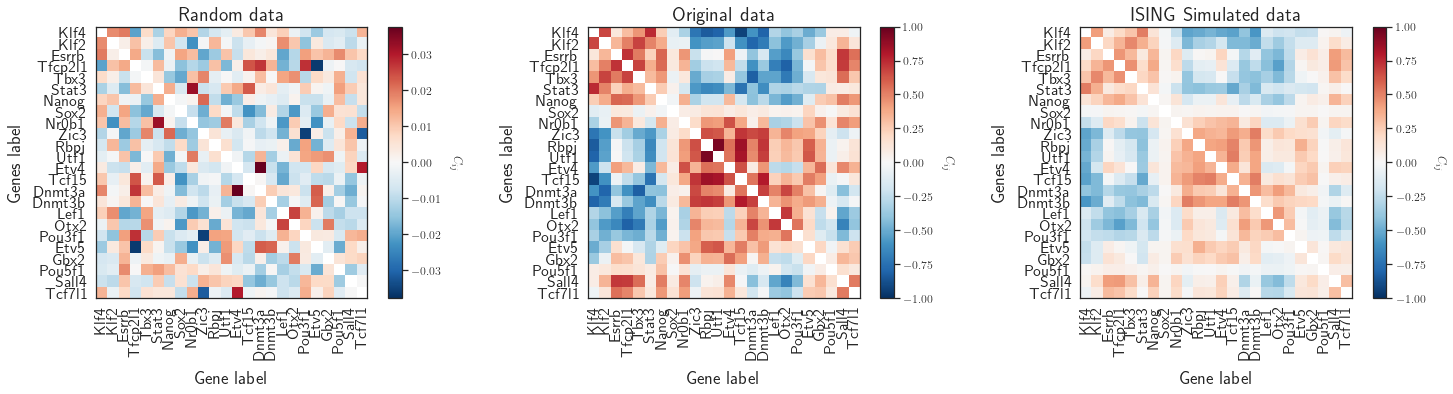

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
figfunc.plotmat(corr_matxs_rnd_pN_noDiag, fig, ax[0], genes_order, "Random data", )
figfunc.plotmat(cm_original_pN_noDiag, fig, ax[1], genes_order, "Original data", fix=True)
figfunc.plotmat(cm_sim_pN_mean_noDiag, fig, ax[2], genes_order, "ISING Simulated data", fix=True)
plt.show()



In [53]:
# compute the noise for the distance between matrixes
noise_dist = [funcs_ko.sum_squared_abs_diff(cm_orig_pN_red, corr_matx_rnd_pN_red[i,:,:]) for i in range(50)]
noise_dist = np.mean(noise_dist)
# print(noise_dist)

# compute the  weighted distance between the original and simulated matrixes
result_IO = [funcs_ko.sum_squared_abs_diff(cm_orig_pN_red, cm_sim_pN_red[:,:,i]) for i in range(Ntrials)]
result_IO = np.mean(result_IO)/ noise_dist # normalize by the noise
print(f"Distance between the original and simulated matrixes: {result_IO.round(2)}")


Distance between the original and simulated matrixes: 0.42


### Clustering on Simulated Data

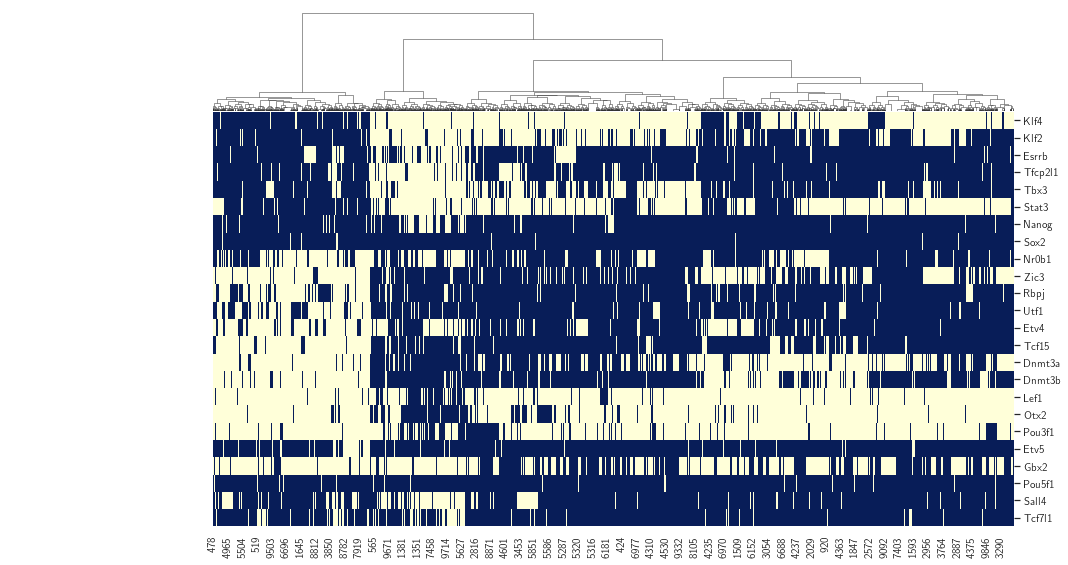

In [54]:
# Perform linkage on your numpy array
jj=10
Z = scipy.cluster.hierarchy.linkage(spins_new_pN[:,:,jj].T, method='ward')
# Note: we are showing just one simulated dataset, but you can do the same for all of them

# Plot the dendrogram and heatmap
sns.clustermap(spins_new_pN[:,:, jj], col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=False, figsize=(15,8), row_cluster=False )
plt.xticks([])
plt.yticks([])
plt.show()


### Clustering on Original Data

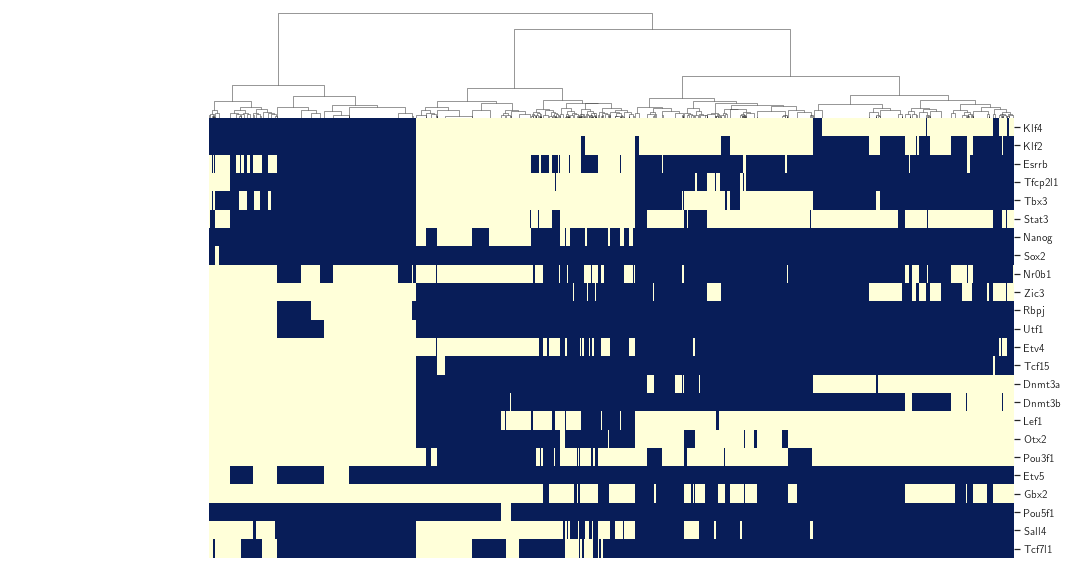

In [55]:
# Perform linkage on your numpy array
Z = scipy.cluster.hierarchy.linkage(spins_df_pN_mb_pst.T, method='ward')

# Plot the dendrogram and heatmap
sns.clustermap(spins_df_pN_mb_pst, col_linkage=Z, cmap='YlGnBu',
               yticklabels=genes_order, xticklabels=[],
               cbar=False, figsize=(15,8), row_cluster=False )

plt.xticks([])
plt.yticks([])

plt.show()

# Knock Out

In [56]:
thr_KO_Leeb = 0
thr_KO = thr_KO_Leeb

### Leeb data

In [57]:
df_KO_N24_Leeb_uncl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_uncleaned.csv', index_col=0, header=0)
df_KO_N24_Leeb_uncl.head(2)


,Rbpj,Etv5,Tcf7l1
Klf4,2.890194,2.386695,1.300426
Klf2,0.492426,1.008604,2.338680


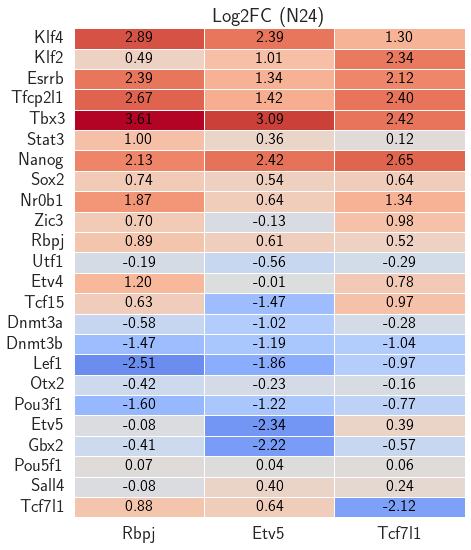

In [58]:
plt.figure(figsize=(7,9))
# annotate using 3 decimal places
sns.heatmap(np.array(df_KO_N24_Leeb_uncl).astype(float), annot=True, fmt=".2f", 
            xticklabels=df_KO_N24_Leeb_uncl.columns, yticklabels=df_KO_N24_Leeb_uncl.index, 
           cmap="coolwarm", cbar=False, center=0, linewidth=.5, annot_kws={"size":16, 'color':'black'})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Log2FC (N24)", fontsize=20)
plt.show()

## Kalkan Data

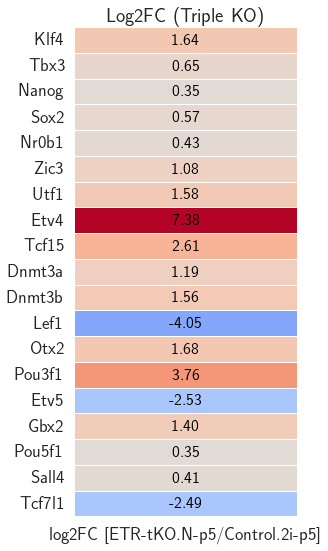

In [59]:
# exp logFC
df_tKO_Kalkan= pd.read_csv(path_data+'Kalkan_Data/df_tripleKO.csv', index_col=0, header=0)

plt.figure(figsize=(4,9))
# annotate using 3 decimal places
sns.heatmap(np.array(df_tKO_Kalkan).astype(float), annot=True, fmt=".2f", 
            xticklabels=df_tKO_Kalkan.columns, yticklabels=df_tKO_Kalkan.index, 
           cmap="coolwarm", cbar=False, center=0, linewidth=.5, annot_kws={"size":16, 'color':'black'})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Log2FC (Triple KO)", fontsize=20)
plt.show()

## PsiNorm

In [60]:
N_test_KO=100

### KO Rbpj

/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:135: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  slist[:,idx+1] = asynch_glauber_dynamics(h, J, slist[:,idx], delta_t, gamma)


KO_std-wt_std not significant for gene  ['Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Nr0b1' 'Zic3'
 'Utf1' 'Etv4' 'Dnmt3a' 'Dnmt3b' 'Lef1' 'Otx2' 'Pou3f1' 'Etv5' 'Gbx2'
 'Pou5f1' 'Sall4' 'Tcf7l1']
Number of genes in agreement:  0.5
Number of genes considered:  2
Genes considered:  ['Klf4' 'Tcf15']


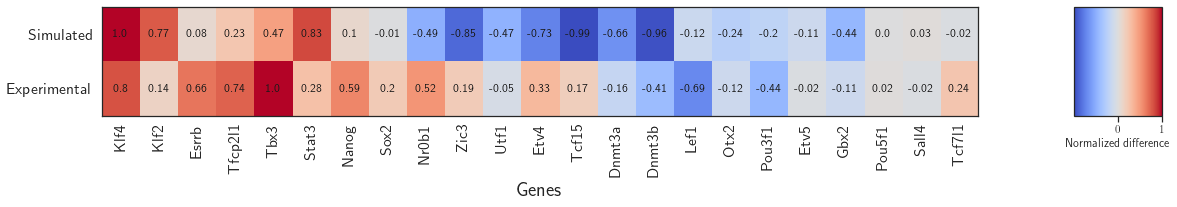

In [61]:
KO_gene = "Rbpj"

diff_pN_Rbpj, exp_logFC_Rbpj, KO_genes_order_Rbpj = funcs_ko.KO_wrap(KO_gene, pN_high_meanMatx, model_pN_best, genes_order, spins_new_pN, df_KO_N24_Leeb_uncl, N_test_KO=N_test_KO)

### KO Etv5

KO_std-wt_std not significant for gene  ['Klf4' 'Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Nr0b1'
 'Zic3' 'Etv4' 'Tcf15' 'Dnmt3a' 'Dnmt3b' 'Lef1' 'Otx2' 'Pou3f1' 'Gbx2'
 'Pou5f1' 'Sall4' 'Tcf7l1']
Number of genes in agreement:  0.5
Number of genes considered:  2
Genes considered:  ['Rbpj' 'Utf1']


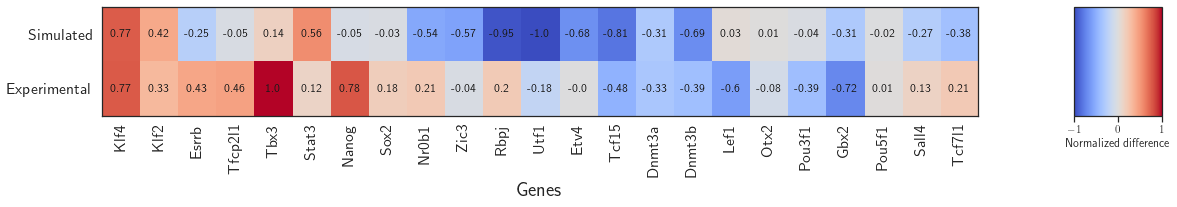

In [62]:
KO_gene = "Etv5"

diff_pN_Etv5, exp_logFC_Etv5, KO_genes_order_Etv5 = funcs_ko.KO_wrap(KO_gene, pN_high_meanMatx, model_pN_best, genes_order, spins_new_pN, df_KO_N24_Leeb_uncl, N_test_KO=N_test_KO)

### KO Tcf7l1

KO_std-wt_std not significant for gene  ['Klf4' 'Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Nr0b1'
 'Zic3' 'Rbpj' 'Utf1' 'Etv4' 'Tcf15' 'Dnmt3a' 'Dnmt3b' 'Lef1' 'Otx2'
 'Pou3f1' 'Etv5' 'Gbx2' 'Pou5f1' 'Sall4']
Number of genes in agreement:  0
Number of genes considered:  0
Genes considered:  []


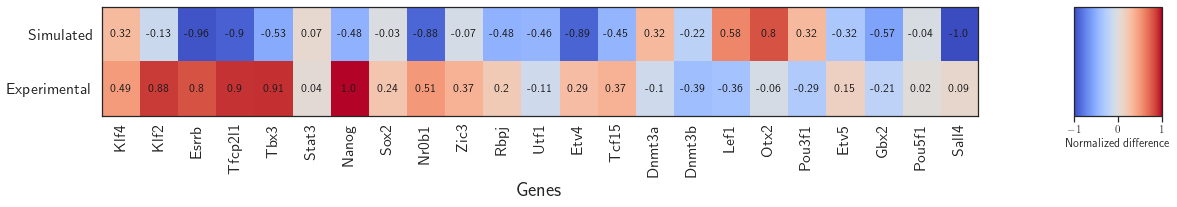

In [63]:
KO_gene = "Tcf7l1"

diff_pN_Tcf7l1, exp_logFC_Tcf7l1, KO_genes_order_Tcf7l1 = funcs_ko.KO_wrap(KO_gene, pN_high_meanMatx, model_pN_best, genes_order, spins_new_pN, df_KO_N24_Leeb_uncl, N_test_KO=N_test_KO)

### KO of three genes

In [64]:
# exp logFC
# df_tKO_Kalkan = pd.read_csv(path_data+'Kalkan_Data/df_tripleKO.csv', index_col=0, header=0)

df_tKO_Kalkan = pd.read_csv(path_data+'Kalkan_Data/df_tripleKO_diff.csv', index_col=0, header=0)


In [65]:
KO_gene_T_spins = ["Rbpj", "Etv5", "Tcf7l1"]

KO_pN_rec_matx_T_spins, KO_pN_rec_field_T_spins, KO_gene_idk_T, KO_genes_order_T = funcs_ko.info_KO(pN_high_meanMatx, model_pN_best, KO_gene_T_spins,
                                                                               genes_order=genes_order, multiple=True)

wt_pN_mb_pst_spins_forKO_T = np.delete(np.array(spins_new_pN),KO_gene_idk_T, axis=0)+1

# generate KO activity
KO_T_spins = funcs_ko.KO_activity_sim(KO_pN_rec_matx_T_spins, KO_pN_rec_field_T_spins, KO_genes_order_T, model_pN_best, N_test_KO=500, n_time=10000)

# average activity for KO and wt
KO_T_weighted_avg, KO_T_weighted_std, wt_T_avg, wt_T_std = funcs_ko.KO3_avg_weighted(KO_T_spins+1, wt_pN_mb_pst_spins_forKO_T)
# plot average KO and wt activity for each gene 
# funcs_ko.KO_plots_SimMultiple(KO_T_weighted_avg, KO_T_weighted_std, wt_T_avg, wt_T_std, KO_genes_order_T)



In [66]:
# remove row of the KO
df_tKO_Kalkan_sel =df_tKO_Kalkan.drop(["Etv5", "Rbpj", "Tcf7l1"])
# search gene present in genes_order and absent in df_tKO_Kalkan_sel and thei indices
common_genes = [x for x in KO_genes_order_T if x in df_tKO_Kalkan_sel.index]
common_genes_idx = [x for x in range(len(KO_genes_order_T)) if KO_genes_order_T[x] in df_tKO_Kalkan_sel.index]
print(common_genes)

# select only simulated KO and WT for which we know experimental tKO
KO_T_weighted_avg_sel_T = KO_T_weighted_avg[common_genes_idx]
KO_T_weighted_std_sel_T = KO_T_weighted_std[common_genes_idx]
wt_T_avg_sel_T = wt_T_avg[common_genes_idx]
wt_T_std_sel_T = wt_T_std[common_genes_idx]

diff_sim_T, diff_sim_std_T, idx_notS_T = funcs_ko.KO_diff_sim(KO_T_weighted_avg_sel_T, KO_T_weighted_std_sel_T ,wt_T_avg_sel_T, wt_T_std_sel_T, thr_significance=3)

# funcs_ko.KO_plof_Diff_LogFC(df_tKO_Kalkan_sel, diff_sim_T, diff_sim_std_T, common_genes, idx_notS_T, 'Difference between WT and KO in Simulated data and Experimental logFC', n_sigma=3)
# funcs_ko.KO_plof_Diff_LogFC_heat(np.array(df_tKO_Kalkan_sel), diff_sim_T, diff_sim_std_T, np.array(common_genes), "", n_sigma=1)

in_agreement_pN_T, data_considered_pN_T, considered_genes_pN_T = funcs_ko.KO_diff_ExpVsSim(np.array(df_tKO_Kalkan_sel.iloc[:,0]), diff_sim_T, diff_sim_std_T, np.array(common_genes))
print("Number of genes in agreement: ", in_agreement_pN_T)
print("Number of genes considered: ", data_considered_pN_T)

['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Nanog', 'Sox2', 'Nr0b1', 'Zic3', 'Utf1', 'Etv4', 'Tcf15', 'Dnmt3a', 'Dnmt3b', 'Lef1', 'Otx2', 'Pou3f1', 'Gbx2', 'Pou5f1', 'Sall4']
KO_std-wt_std not significant for gene  ['Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Zic3' 'Dnmt3a'
 'Lef1' 'Otx2' 'Pou3f1' 'Gbx2' 'Pou5f1' 'Sall4']
Number of genes in agreement:  0.8333333333333334
Number of genes considered:  6


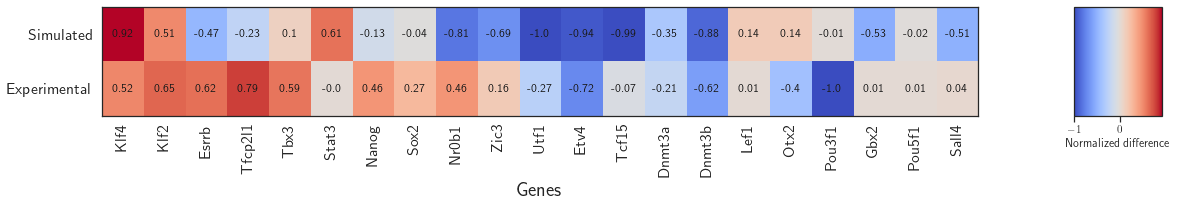

In [67]:
funcs_ko.KO_heat_comparison_T(diff_sim_T, np.array(df_tKO_Kalkan_sel).squeeze(), "", np.array(common_genes), Norm=True)


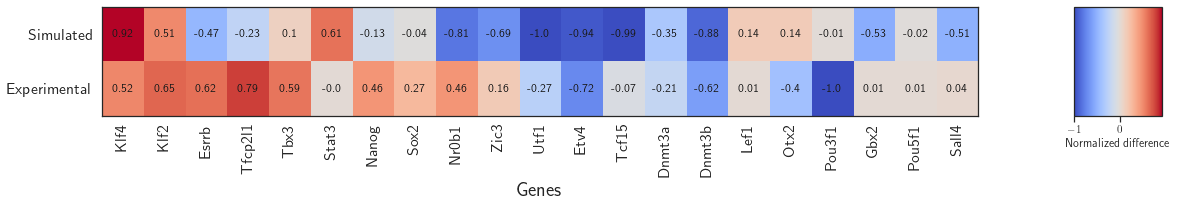

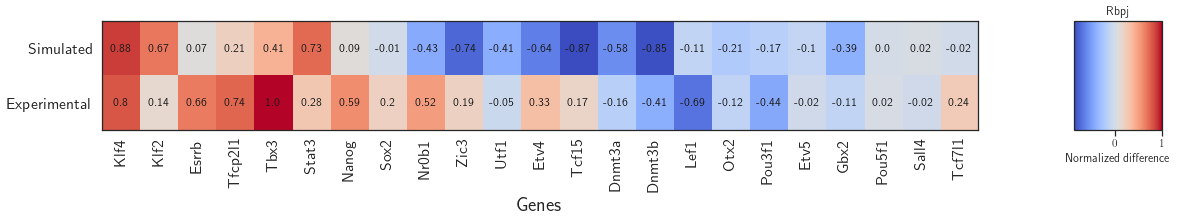

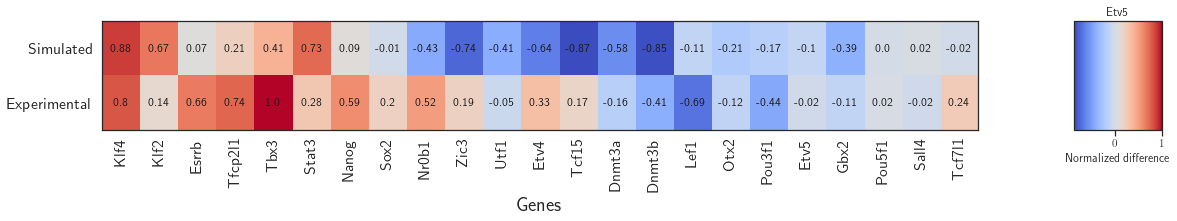

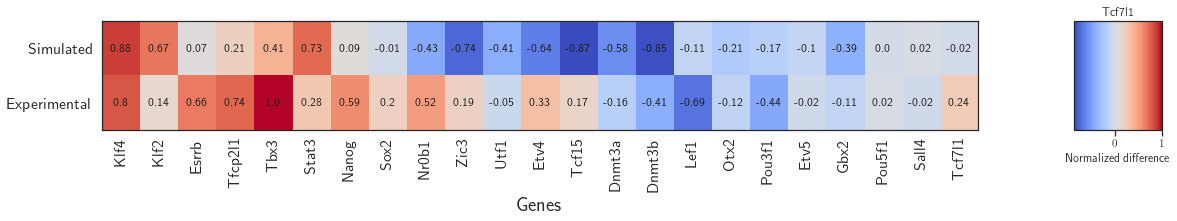

In [69]:
# Normalized differences
diff_sim   = np.array([diff_pN_Rbpj, diff_pN_Etv5, diff_pN_Tcf7l1])
log2FC_exp = np.array([exp_logFC_Rbpj, exp_logFC_Etv5, exp_logFC_Tcf7l1])
genes_KOs  = np.array([KO_genes_order_Rbpj, KO_genes_order_Etv5, KO_genes_order_Tcf7l1])

diff_max = max(np.abs(diff_sim).max(), np.abs(diff_sim_T).max())
diff_sim_norm = diff_sim/diff_max
diff_sim_T_norm = diff_sim_T/diff_max

log2FC_exp_norm = log2FC_exp/np.abs(log2FC_exp).max()
# diff_pN_Tcf7l1, exp_logFC_Tcf7l1, KO_genes_order_Tcf7l1 


# Triple
funcs_ko.KO_heat_comparison_T(diff_sim_T_norm, np.array(df_tKO_Kalkan_sel).squeeze(), "", np.array(common_genes), Norm=False)

# Rbpj
funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Rbpj", genes_KOs[0,:], Norm=False)

# Etv5
funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Etv5", genes_KOs[0,:], Norm=False)

# Tcf7l1
funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Tcf7l1", genes_KOs[0,:], Norm=False)


In [70]:
# diff_sim_T, diff_sim_std_T, idx_notS_T = funcs_ko.KO_diff_sim(KO_T_weighted_avg_sel_T, KO_T_weighted_std_sel_T ,wt_T_avg_sel_T, wt_T_std_sel_T, thr_significance=3)

# funcs_ko.KO_plof_Diff_LogFC(df_tKO_Kalkan_sel, diff_sim_T, diff_sim_std_T, common_genes, idx_notS_T, 'Difference between WT and KO in Simulated data and Experimental logFC', n_sigma=3)

# in_agreement_pN_T, data_considered_pN_T, considered_genes_pN_T = funcs_ko.KO_diff_ExpVsSim(np.array(df_tKO_Kalkan_sel.iloc[:,0]), diff_sim_T, diff_sim_std_T, np.array(common_genes))
# print("Number of genes in agreement: ", in_agreement_pN_T)
# print("Number of genes considered: ", data_considered_pN_T)

In [71]:
# fun_plotting.raster_plot(KO_T_spins[:,:,1], 'Reconstruction', 1, KO_genes_order_T)
# plt.show()

/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/funcs_ko.py:674: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ko_genes_order, fontsize=12)


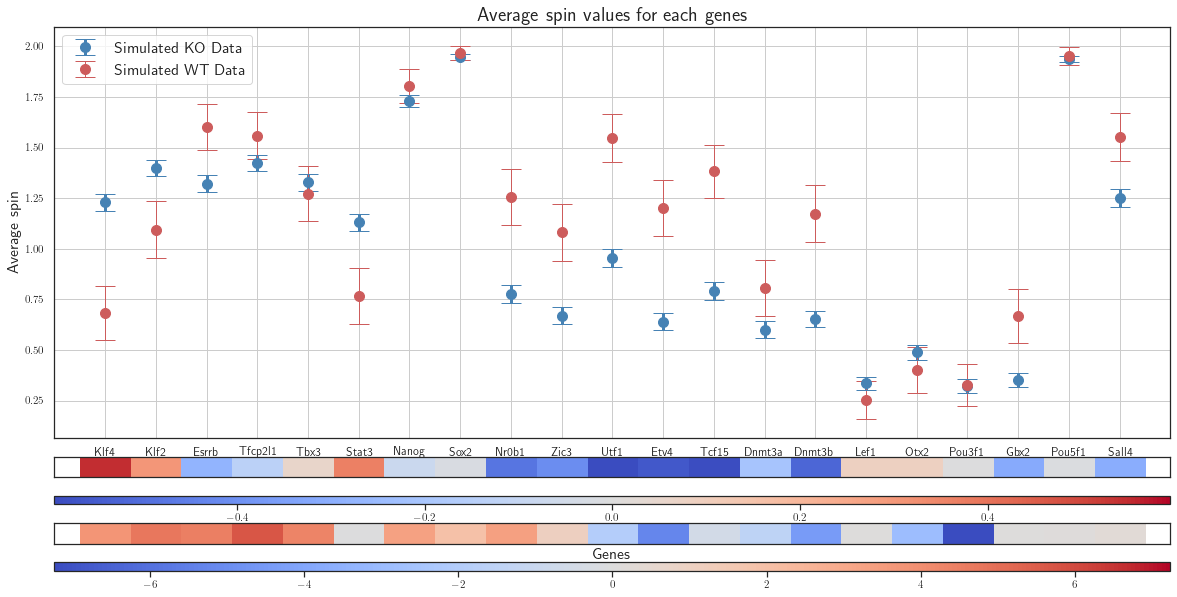

In [72]:
funcs_ko.KO_plots_oneSim_T(diff_sim_T, KO_T_weighted_avg_sel_T, KO_T_weighted_std_sel_T, wt_T_avg_sel_T, wt_T_std_sel_T, np.array(common_genes), exp_data=np.array(df_tKO_Kalkan_sel.iloc[:,0]))

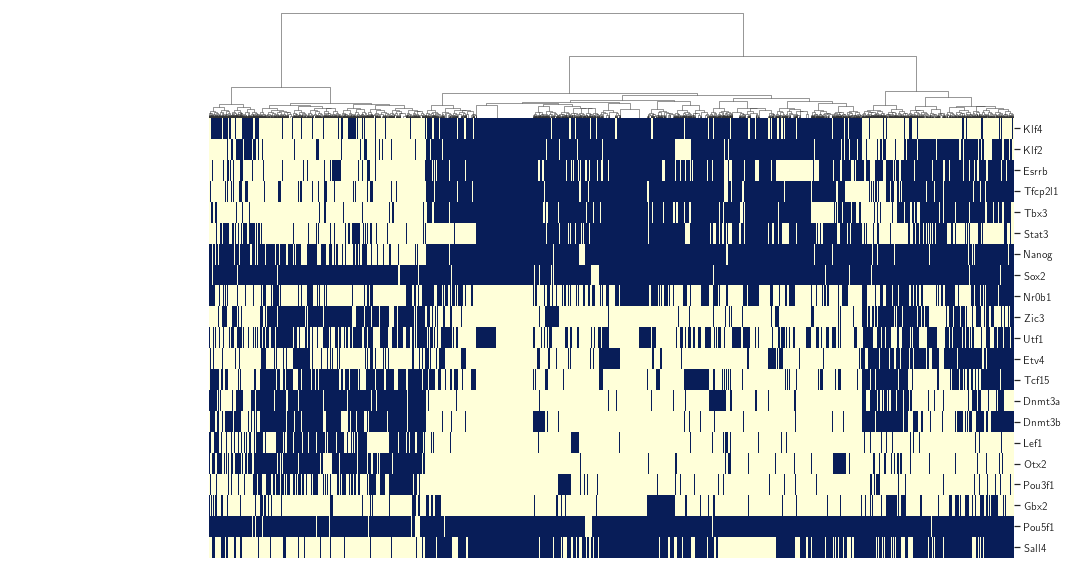

In [73]:
# Perform linkage on your numpy array
Z = scipy.cluster.hierarchy.linkage(KO_T_spins[:,:,1].T, method='ward')

# Plot the dendrogram and heatmap
sns.clustermap(KO_T_spins[:,:,1], col_linkage=Z, cmap='YlGnBu',
               yticklabels=KO_genes_order_T, xticklabels=[],
               cbar=False, figsize=(15,8), row_cluster=False )

plt.xticks([])
plt.yticks([])

plt.show()

## LogNorm

### KO Rbpj

KO_std-wt_std not significant for gene  ['Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Zic3' 'Dnmt3a' 'Dnmt3b'
 'Lef1' 'Otx2' 'Pou3f1' 'Gbx2' 'Pou5f1' 'Sall4' 'Tcf7l1']
Number of genes in agreement:  0.5714285714285714
Number of genes considered:  7
Genes considered:  ['Klf4' 'Klf2' 'Nr0b1' 'Utf1' 'Etv4' 'Tcf15' 'Etv5']


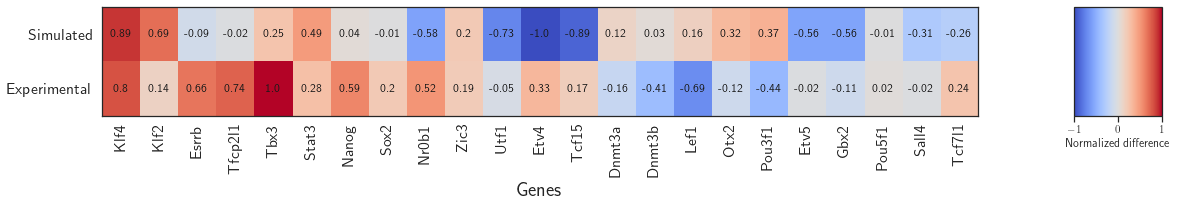

(array([ 0.73085 ,  0.565888, -0.073548, -0.017278,  0.204074,  0.397156,
         0.029976, -0.005986, -0.471508,  0.167104, -0.593044, -0.81755 ,
        -0.72504 ,  0.09768 ,  0.028234,  0.126868,  0.262318,  0.303016,
        -0.459876, -0.460668, -0.005932, -0.255084, -0.212008]),
 array([ 2.89019365,  0.49242566,  2.39119745,  2.67266895,  3.61462072,
         1.00171556,  2.13390927,  0.73863614,  1.87418193,  0.69676128,
        -0.19466999,  1.19728592,  0.63221357, -0.57924311, -1.46560346,
        -2.50973151, -0.41949947, -1.59671826, -0.08315646, -0.40807069,
         0.06625728, -0.07749044,  0.87694732]),
 array(['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Nanog',
        'Sox2', 'Nr0b1', 'Zic3', 'Utf1', 'Etv4', 'Tcf15', 'Dnmt3a',
        'Dnmt3b', 'Lef1', 'Otx2', 'Pou3f1', 'Etv5', 'Gbx2', 'Pou5f1',
        'Sall4', 'Tcf7l1'], dtype='<U7'))

In [74]:
# KO info
KO_gene = "Rbpj"

funcs_ko.KO_wrap(KO_gene, lN_high_meanMatx, model_lN_best, genes_order, spins_new_lN, df_KO_N24_Leeb_uncl, N_test_KO=N_test_KO)

### KO Etv5

KO_std-wt_std not significant for gene  ['Klf4' 'Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Nr0b1'
 'Zic3' 'Rbpj' 'Utf1' 'Etv4' 'Tcf15' 'Dnmt3a' 'Dnmt3b' 'Lef1' 'Otx2'
 'Pou3f1' 'Gbx2' 'Pou5f1' 'Sall4' 'Tcf7l1']
Number of genes in agreement:  0
Number of genes considered:  0
Genes considered:  []


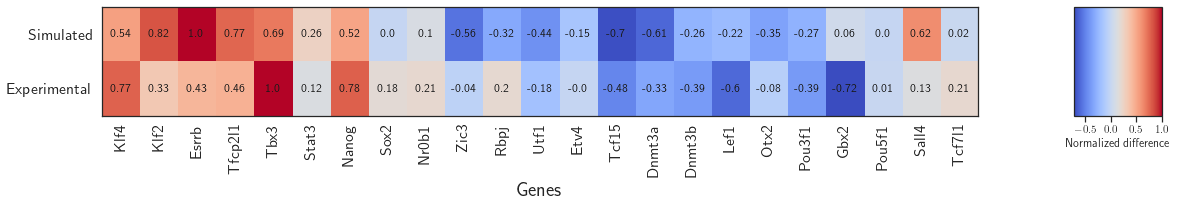

(array([ 1.47030e-01,  2.22558e-01,  2.71546e-01,  2.07758e-01,
         1.88204e-01,  7.04740e-02,  1.41484e-01,  6.80000e-05,
         2.78400e-02, -1.51352e-01, -8.56080e-02, -1.18184e-01,
        -4.11240e-02, -1.89488e-01, -1.65066e-01, -7.01020e-02,
        -5.88980e-02, -9.54900e-02, -7.38580e-02,  1.59240e-02,
         1.00000e-05,  1.68134e-01,  4.64800e-03]),
 array([ 2.38669489,  1.00860353,  1.33974761,  1.42147818,  3.08858783,
         0.3642767 ,  2.42419575,  0.54054997,  0.63798951, -0.13045509,
         0.6069682 , -0.55670783, -0.01010231, -1.47231395, -1.02028908,
        -1.19290854, -1.85920405, -0.23397829, -1.21542657, -2.21511927,
         0.04093834,  0.39531766,  0.64373842]),
 array(['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Nanog',
        'Sox2', 'Nr0b1', 'Zic3', 'Rbpj', 'Utf1', 'Etv4', 'Tcf15', 'Dnmt3a',
        'Dnmt3b', 'Lef1', 'Otx2', 'Pou3f1', 'Gbx2', 'Pou5f1', 'Sall4',
        'Tcf7l1'], dtype='<U7'))

In [75]:
# KO info
KO_gene = "Etv5"

funcs_ko.KO_wrap(KO_gene, lN_high_meanMatx, model_lN_best, genes_order, spins_new_lN, df_KO_N24_Leeb_uncl, N_test_KO=N_test_KO)


### KO Tcf7l1

KO_std-wt_std not significant for gene  ['Klf4' 'Klf2' 'Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Rbpj'
 'Utf1' 'Etv4' 'Tcf15' 'Dnmt3a' 'Dnmt3b' 'Lef1' 'Etv5' 'Gbx2' 'Pou5f1']
Number of genes in agreement:  0.2
Number of genes considered:  5
Genes considered:  ['Nr0b1' 'Zic3' 'Otx2' 'Pou3f1' 'Sall4']


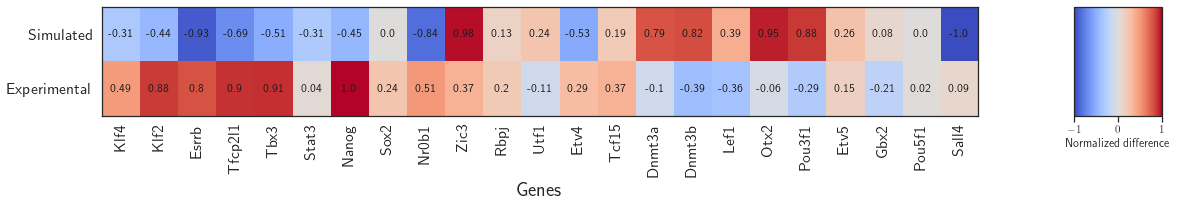

(array([-0.159254, -0.224298, -0.471728, -0.35017 , -0.261316, -0.15649 ,
        -0.229718,  0.001392, -0.425712,  0.49943 ,  0.064532,  0.120784,
        -0.26686 ,  0.095786,  0.402392,  0.415422,  0.19947 ,  0.483752,
         0.448564,  0.133286,  0.041506,  0.000992, -0.507926]),
 array([ 1.30042638,  2.33867993,  2.12391654,  2.39580915,  2.41548067,
         0.11866287,  2.65049627,  0.63695067,  1.33997984,  0.97595693,
         0.51874945, -0.28706792,  0.77501558,  0.96873106, -0.27584412,
        -1.03780687, -0.96639073, -0.16108308, -0.77267765,  0.39214033,
        -0.56525567,  0.06027707,  0.24272167]),
 array(['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Nanog',
        'Sox2', 'Nr0b1', 'Zic3', 'Rbpj', 'Utf1', 'Etv4', 'Tcf15', 'Dnmt3a',
        'Dnmt3b', 'Lef1', 'Otx2', 'Pou3f1', 'Etv5', 'Gbx2', 'Pou5f1',
        'Sall4'], dtype='<U7'))

In [76]:
# KO info
KO_gene = "Tcf7l1"

funcs_ko.KO_wrap(KO_gene, lN_high_meanMatx, model_lN_best, genes_order, spins_new_lN, df_KO_N24_Leeb_uncl, N_test_KO=N_test_KO)


### KO of three genes

In [77]:
KO_gene_T_spins = ["Rbpj", "Etv5", "Tcf7l1"]

KO_lN_rec_matx_T_spins, KO_lN_rec_field_T_spins, KO_gene_idk_T, KO_genes_order_T = funcs_ko.info_KO(lN_high_meanMatx, model_lN_best, KO_gene_T_spins,
                                                                               genes_order=genes_order, multiple=True)

wt_lN_mb_pst_spins_forKO_T = np.delete(np.array(spins_new_lN),KO_gene_idk_T, axis=0)+1

# generate KO activity
KO_T_spins = funcs_ko.KO_activity_sim(KO_lN_rec_matx_T_spins, KO_lN_rec_field_T_spins, KO_genes_order_T, model_lN_best, N_test_KO=500, n_time=10000)

# average activity for KO and wt
KO_T_weighted_avg, KO_T_weighted_std, wt_T_avg, wt_T_std = funcs_ko.KO3_avg_weighted(KO_T_spins+1, wt_lN_mb_pst_spins_forKO_T)
# plot average KO and wt activity for each gene 
# funcs_ko.KO_plots_SimMultiple(KO_T_weighted_avg, KO_T_weighted_std, wt_T_avg, wt_T_std, KO_genes_order_T)



In [78]:
# remove row of the KO
df_tKO_Kalkan_sel =df_tKO_Kalkan.drop(["Etv5","Rbpj", "Tcf7l1"])
# search gene present in genes_order and absent in df_tKO_Kalkan_sel and thei indices
common_genes = [x for x in KO_genes_order_T if x in df_tKO_Kalkan_sel.index]
common_genes_idx = [x for x in range(len(KO_genes_order_T)) if KO_genes_order_T[x] in df_tKO_Kalkan_sel.index]
print(common_genes)

# select only simulated KO and WT for which we know experimental tKO
KO_T_weighted_avg_sel_T = KO_T_weighted_avg[common_genes_idx]
KO_T_weighted_std_sel_T = KO_T_weighted_std[common_genes_idx]
wt_T_avg_sel_T = wt_T_avg[common_genes_idx]
wt_T_std_sel_T = wt_T_std[common_genes_idx]

diff_sim_T, diff_sim_std_T, idx_notS_T = funcs_ko.KO_diff_sim(KO_T_weighted_avg_sel_T, KO_T_weighted_std_sel_T ,wt_T_avg_sel_T, wt_T_std_sel_T, thr_significance=3)

# funcs_ko.KO_plof_Diff_LogFC(df_tKO_Kalkan_sel, diff_sim_T, diff_sim_std_T, common_genes, idx_notS_T, 'Difference between WT and KO in Simulated data and Experimental logFC', n_sigma=3)
# funcs_ko.KO_plof_Diff_LogFC_heat(np.array(df_tKO_Kalkan_sel), diff_sim_T, diff_sim_std_T, np.array(common_genes), "", n_sigma=1)

in_agreement_lN_T, data_considered_lN_T, considered_genes_lN_T = funcs_ko.KO_diff_ExpVsSim(np.array(df_tKO_Kalkan_sel.iloc[:,0]), diff_sim_T, diff_sim_std_T, np.array(common_genes))
print("Number of genes in agreement: ", in_agreement_lN_T)
print("Number of genes considered: ", data_considered_lN_T)

['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Nanog', 'Sox2', 'Nr0b1', 'Zic3', 'Utf1', 'Etv4', 'Tcf15', 'Dnmt3a', 'Dnmt3b', 'Lef1', 'Otx2', 'Pou3f1', 'Gbx2', 'Pou5f1', 'Sall4']
KO_std-wt_std not significant for gene  ['Esrrb' 'Tfcp2l1' 'Tbx3' 'Stat3' 'Nanog' 'Sox2' 'Zic3' 'Dnmt3a' 'Dnmt3b'
 'Lef1' 'Otx2' 'Gbx2' 'Pou5f1' 'Sall4']
Number of genes in agreement:  0.7142857142857143
Number of genes considered:  7


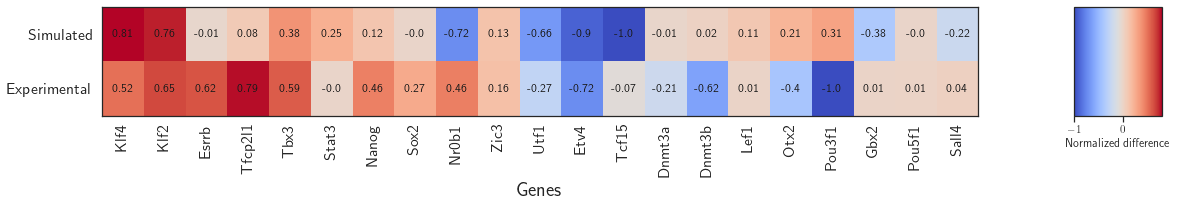

In [79]:
funcs_ko.KO_heat_comparison_T(diff_sim_T, np.array(df_tKO_Kalkan_sel).squeeze(), "", np.array(common_genes))


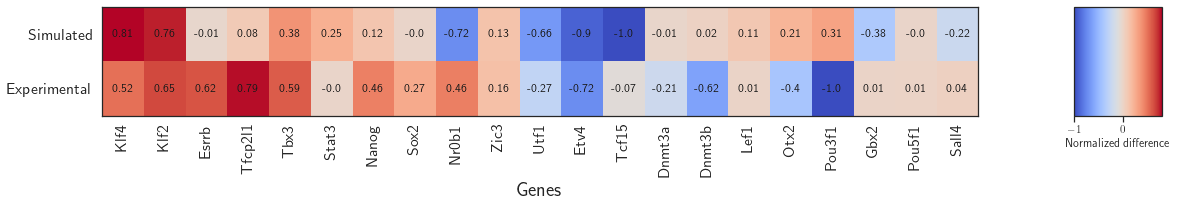

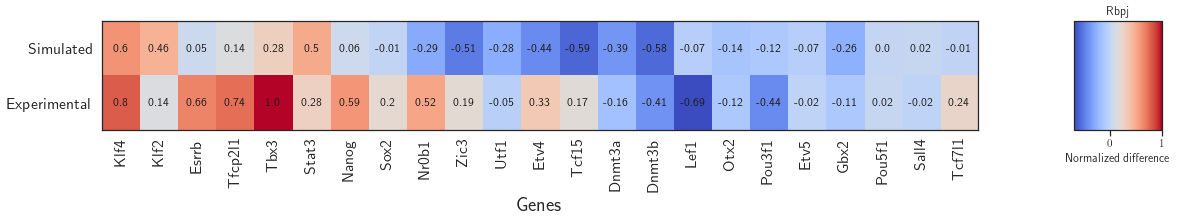

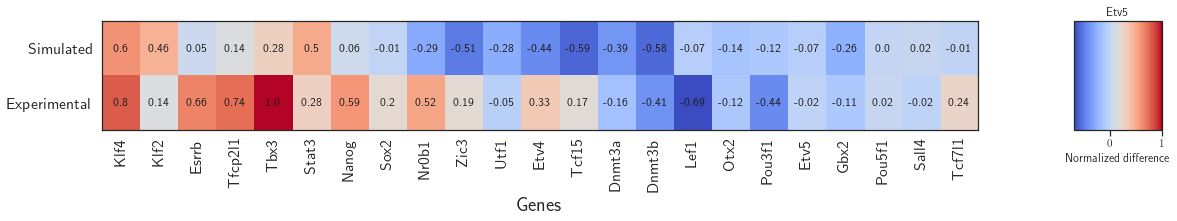

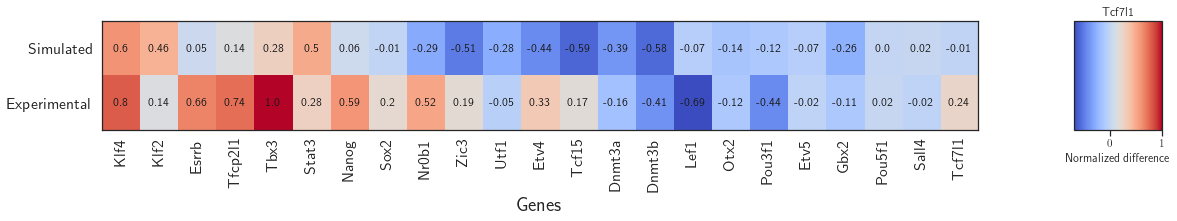

In [95]:
# # Normalized differences
diff_sim   = np.array([diff_pN_Rbpj, diff_pN_Etv5, diff_pN_Tcf7l1])
log2FC_exp = np.array([exp_logFC_Rbpj, exp_logFC_Etv5, exp_logFC_Tcf7l1])
genes_KOs  = np.array([KO_genes_order_Rbpj, KO_genes_order_Etv5, KO_genes_order_Tcf7l1])

diff_max = max(np.abs(diff_sim).max(), np.abs(diff_sim_T).max())
diff_sim_norm = diff_sim/diff_max
diff_sim_T_norm = diff_sim_T/diff_max

log2FC_exp_norm = log2FC_exp/np.abs(log2FC_exp).max()
# diff_pN_Tcf7l1, exp_logFC_Tcf7l1, KO_genes_order_Tcf7l1 


# Triple
funcs_ko.KO_heat_comparison_T(diff_sim_T_norm, np.array(df_tKO_Kalkan_sel).squeeze(), "", np.array(common_genes), Norm=False)

# Rbpj
funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Rbpj", genes_KOs[0,:], Norm=False)

# Etv5
funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Etv5", genes_KOs[0,:], Norm=False)

# Tcf7l1
funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Tcf7l1", genes_KOs[0,:], Norm=False)


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/funcs_ko.py:674: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ko_genes_order, fontsize=12)


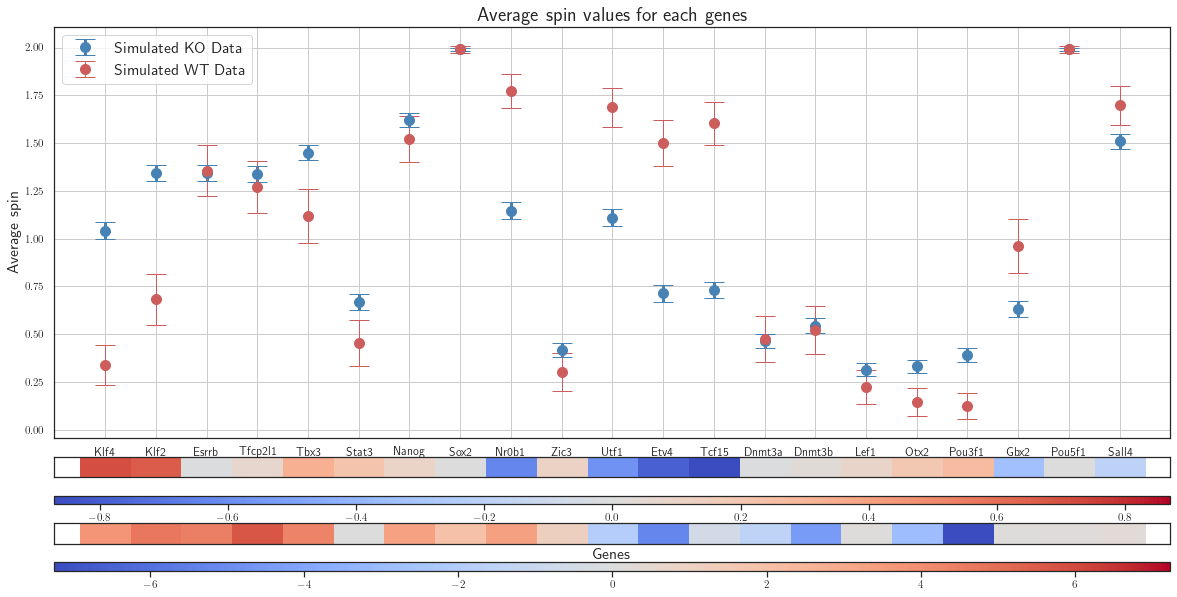

In [81]:
# funcs_ko.KO_plots_oneSim(KO_T_spins[:,:,1], KO_T_weighted_avg, KO_T_weighted_std, wt_T_avg, wt_T_std, ko_genes_order=KO_genes_order_T, exp_data=np.array(df_tKO_Kalkan_sel.iloc[:,0]), raster=False)

funcs_ko.KO_plots_oneSim_T(diff_sim_T, KO_T_weighted_avg_sel_T, KO_T_weighted_std_sel_T, wt_T_avg_sel_T, wt_T_std_sel_T, np.array(common_genes), exp_data=np.array(df_tKO_Kalkan_sel.iloc[:,0]))

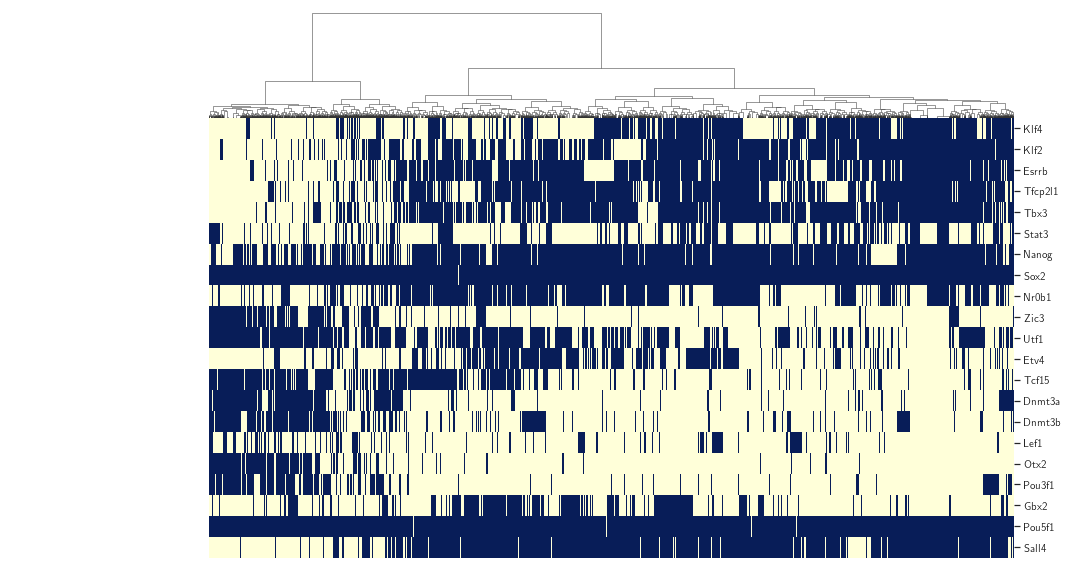

In [82]:
# Perform linkage on your numpy array
Z = scipy.cluster.hierarchy.linkage(KO_T_spins[:,:,1].T, method='ward')

# Plot the dendrogram and heatmap
sns.clustermap(KO_T_spins[:,:,1], col_linkage=Z, cmap='YlGnBu',
               yticklabels=KO_genes_order_T, xticklabels=[],
               cbar=False, figsize=(15,8), row_cluster=False )

plt.xticks([])
plt.yticks([])

plt.show()

# Network Analysis: LogNorm

Adjacency matrix

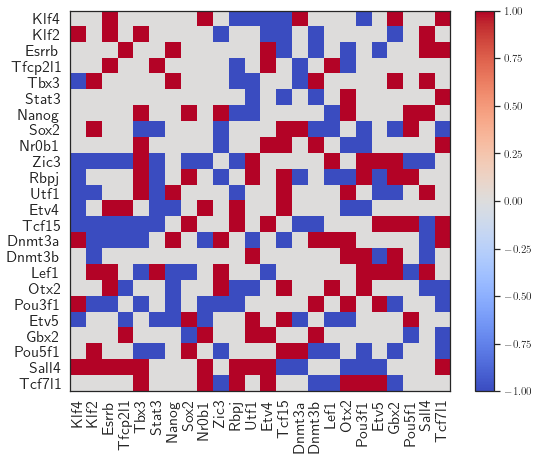

%1s : 0.22
%-1s : 0.23
%0s : 0.55


In [83]:
adj_matx = na.to_adj_matrix(lN_high_meanMatx, thr = 0.1)
na.adj_plot(adj_matx)

print("%1s :", f"{len(np.where(adj_matx==1)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")
print("%-1s :", f"{len(np.where(adj_matx==-1)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")

print("%0s :", f"{len(np.where(adj_matx==0)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")

In [84]:
# def InteractionList(df, perc=0):
#     output = []
#     for row in df.index:
#         for col in df.columns:
#             element = df.loc[row, col]
#             if element > thr:
#                 sign = "1"
#             elif element < -thr:
#                 sign = "-1"
#             else:
#                 df.loc[row, col] = 0
#                 sign = "0"
# #             if (sign == "-1") or (sign == "1"):
#             output.append(f"{col} {row} {sign}")
#     return(output, df)

# Interactions_list, df = InteractionList(path=path_data+"Leeb_Data_Downloaded/LogFC_Leeb.csv", perc = 0.3)
Interactions_list = TPtrial_list


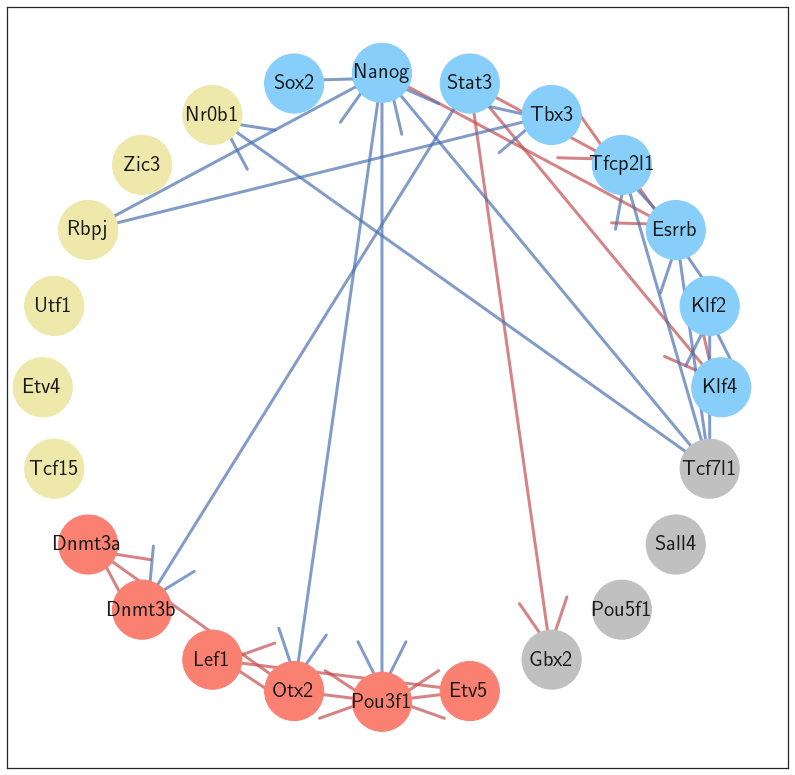

In [85]:
na.visualize_graphTrue(adj_matx, genes_order, naive, formative, committed, Interactions_list,"")# "Expected Interactions (Known Directed Correlations)")   



Network reciprocity 0.5


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/NetAnalysis.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(genes_list, rotation=45, fontsize=16)


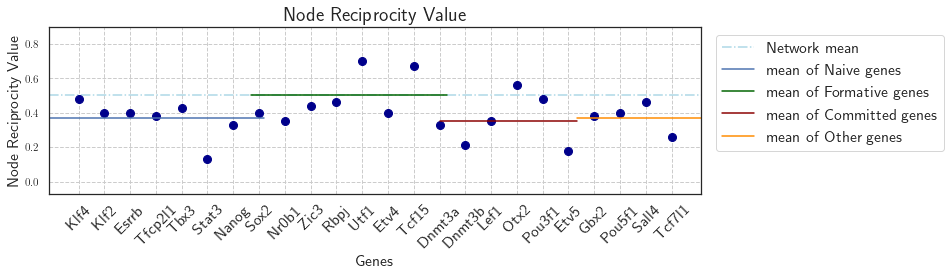

Naive 0.37 +\_ 0.10
Formative 0.50 +\_ 0.13
Committed 0.35 +\_ 0.14
Others 0.38 +\_ 0.07


In [86]:
# Reciprocity
reciprocity_value = na.reciprocity(adj_matx)
print("Network reciprocity", reciprocity_value)

nodes_rec, mean_TypeGenes, std_TypeGenes = na.nodes_reciprocity(adj_matx, net_reciprocity = reciprocity_value, genes_list=genes_order)

print("Naive", "{:.2f}".format(mean_TypeGenes[0]), "+\_", "{:.2f}".format(std_TypeGenes[0]))
print("Formative", "{:.2f}".format(mean_TypeGenes[1]), "+\_", "{:.2f}".format(std_TypeGenes[1]))
print("Committed", "{:.2f}".format(mean_TypeGenes[2]), "+\_", "{:.2f}".format(std_TypeGenes[2]))
print("Others", "{:.2f}".format(mean_TypeGenes[3]), "+\_", "{:.2f}".format( std_TypeGenes[3]))


Degree

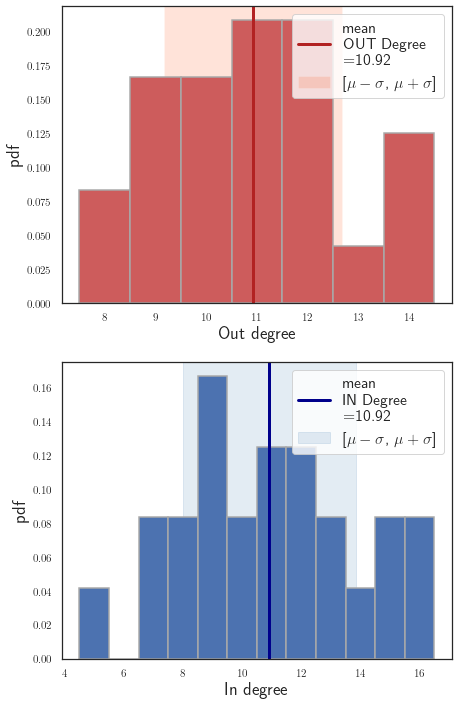

In [87]:
na.plot_degree_distribution(adj_matx)

16.0 14.0


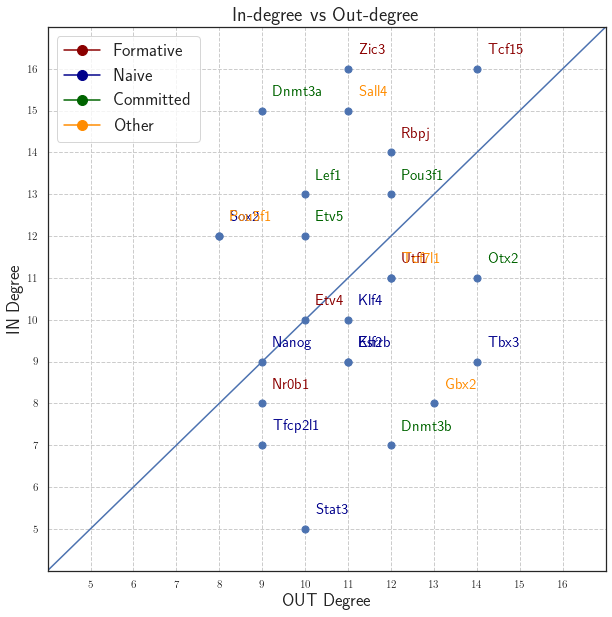

0.07


In [88]:
outdegree, indegree, Sp_corr = na.plot_indegree_outdegree(adj_matx)
print(f"{Sp_corr:.2f}")

## INTERACTION DISTRIBUTION

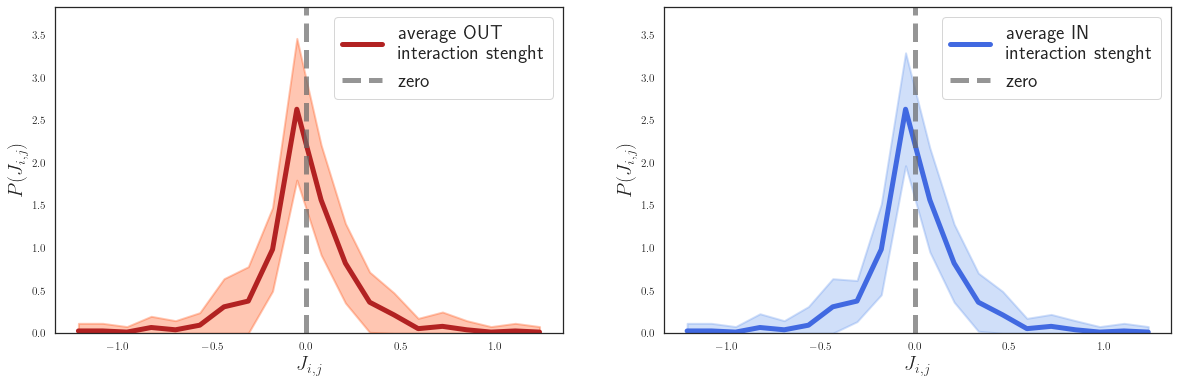

In [89]:
na.plot_histograms(lN_high_meanMatx)


### Hubs

OUT hubs:
 ['Tbx3' 'Tcf15' 'Otx2' 'Gbx2' 'Rbpj']
IN hubs:
 ['Zic3' 'Tcf15' 'Dnmt3a' 'Sall4' 'Rbpj']
OUT hubs


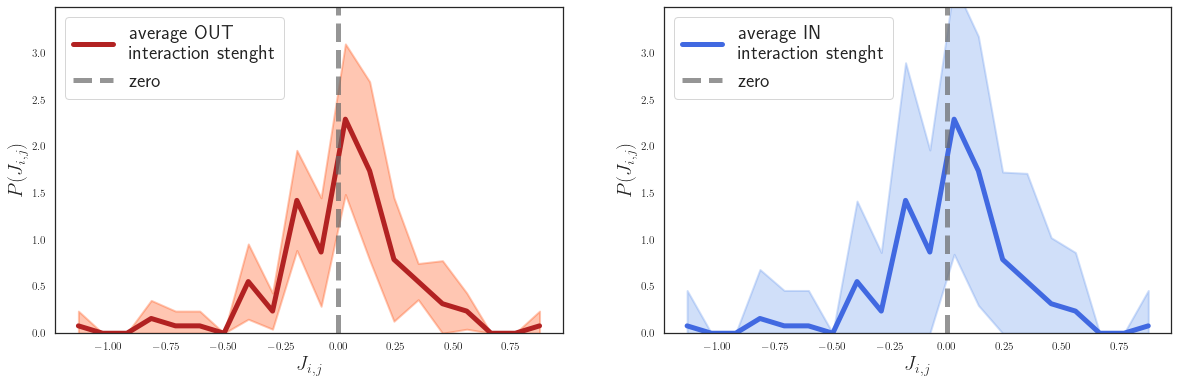

IN hubs


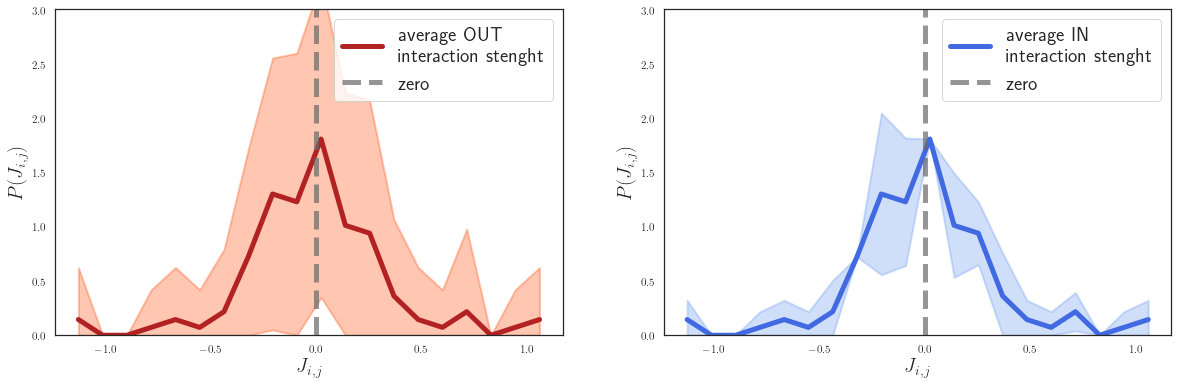

In [90]:
n_hubs = 5
print("OUT hubs:\n", na.highest_OUTdegree_nodes(adj_matx, n_hubs, genes_order)[:,0])
print("IN hubs:\n", na.highest_INdegree_nodes(adj_matx, n_hubs, genes_order)[:,0])

print("OUT hubs")
out_hubs_idxs = na.highest_OUTdegree_nodes(adj_matx, n_hubs, genes_order)[:,2]
na.plot_histograms(lN_high_meanMatx[:,out_hubs_idxs.astype("int")])

print("IN hubs")
in_hubs_idxs = na.highest_INdegree_nodes(adj_matx, n_hubs, genes_order)[:,2]
na.plot_histograms(lN_high_meanMatx[in_hubs_idxs.astype("int"), :])


## NETWORK

In [91]:
# na.visualize_graph_selNode(adj_matx, genes_order, naive, formative, committed, "Nanog")



In [92]:
interactions = na.string_list_to_tuple(TPtrial_list)
correlations_known = na.string_list_to_tuple(Interactions_list)

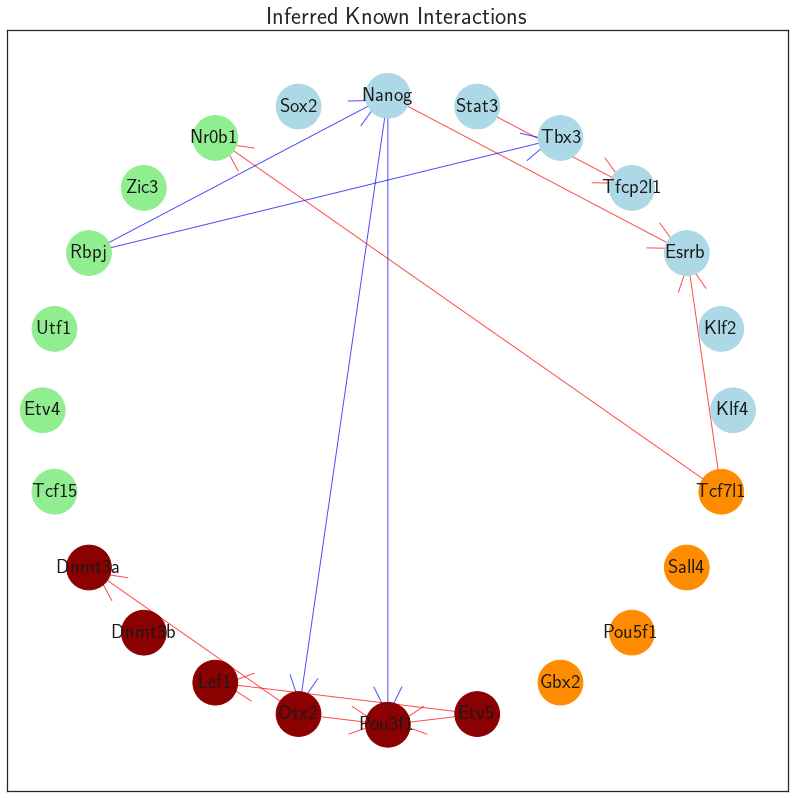

In [93]:
na.visualize_graph_KnownInferred(adj_matx, genes_order, naive, formative, committed,  interactions, "Inferred Known Interactions")


In [94]:
# na.visualize_graph_KnownInferred(adj_matx, genes_order, naive, formative, committed,  correlations_known, "Inferred Known Directed Correlations")
